# Implémentez un modèle de scoring

In [1]:
# Libraries
import pandas as pd
import numpy as np
import warnings
import os
import pickle
import gc
import time
from contextlib import contextmanager
from urllib.parse import urlparse
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer,classification_report,recall_score,precision_score,balanced_accuracy_score,f1_score,confusion_matrix
from sklearn.utils import class_weight
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE,BorderlineSMOTE
import mlflow
import mlflow.sklearn
import mlflow.pyfunc
import shap
import joblib
from mlflow.models.signature import infer_signature

# Disabling warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
%matplotlib inline

In [2]:
df = pd.read_csv(os.path.join('..', 'data', 'preprocessed_data.csv'))
# df['TARGET'].value_counts()

In [3]:
sample_class_0 = df[df['TARGET']==0.0].sample(n=1500,random_state=101)
sample_class_1 = df[df['TARGET']==1.0].sample(n=500,random_state=101)
df_sample = pd.concat([sample_class_0,sample_class_1]).reset_index(drop=True)
df_sample['TARGET'].value_counts()

0.0    1500
1.0     500
Name: TARGET, dtype: int64

In [4]:
df_sample.shape

(2000, 429)

In [5]:
df_sample.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,0.0,Cash loans,0,1,0,0,270000.0,835380.0,42781.5,675000.0,...,7019.876250,84238.515,2407.455,14020.785,7019.876250,84238.515,-1486.0,-1942.416667,-23309.0,12.0
1,0.0,Cash loans,1,0,1,2,85500.0,381528.0,19512.0,315000.0,...,3731.835000,167932.575,2986.335,15494.670,3731.835000,167932.575,-937.0,-1813.755556,-81619.0,45.0
2,0.0,Cash loans,1,0,0,0,405000.0,1546020.0,42642.0,1350000.0,...,9540.646875,152650.350,7411.095,10818.900,9540.646875,152650.350,-953.0,-1093.062500,-17489.0,16.0
3,0.0,Cash loans,1,0,0,0,157500.0,1262583.0,37044.0,1102500.0,...,28337.202000,283372.020,4240.935,90000.000,37337.202000,373372.020,-41.0,-553.100000,-5531.0,10.0
4,0.0,Cash loans,1,0,0,0,81000.0,521280.0,31630.5,450000.0,...,11785.713750,188571.420,15.840,71550.000,11755.338750,188085.420,-56.0,-587.750000,-9404.0,16.0


In [6]:
del df, sample_class_0, sample_class_1

In [7]:
df_sample[df_sample['TARGET'] == 1.0].head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
1500,1.0,Cash loans,1,0,0,0,135000.0,808650.0,26086.5,675000.0,...,13866.687132,1885869.450,0.135,67500.000,13716.012243,1865377.665,-32.0,-776.808824,-105646.0,136.0
1501,1.0,Cash loans,1,1,0,1,225000.0,1436850.0,42142.5,1125000.0,...,11061.358816,420331.635,15.390,119292.975,9288.320921,352956.195,-581.0,-1020.447368,-38777.0,38.0
1502,1.0,Revolving loans,1,0,0,0,180000.0,585000.0,29250.0,585000.0,...,15619.259605,1780595.595,0.045,90440.325,12433.347632,1417401.630,-27.0,-1347.473684,-153612.0,114.0
1503,1.0,Cash loans,1,0,0,0,135000.0,325908.0,13936.5,247500.0,...,19729.985081,1223259.075,767.970,350452.035,17317.692581,1073696.940,-368.0,-843.725806,-52311.0,62.0
1504,1.0,Cash loans,1,1,0,1,135000.0,675000.0,26154.0,675000.0,...,26585.168625,2126813.490,8.325,367749.090,18911.459250,1512916.740,-312.0,-1110.775000,-88862.0,80.0


In [8]:
df_sample[df_sample['TARGET'] == 0.0].head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,0.0,Cash loans,0,1,0,0,270000.0,835380.0,42781.5,675000.0,...,7019.876250,84238.515,2407.455,14020.785,7019.876250,84238.515,-1486.0,-1942.416667,-23309.0,12.0
1,0.0,Cash loans,1,0,1,2,85500.0,381528.0,19512.0,315000.0,...,3731.835000,167932.575,2986.335,15494.670,3731.835000,167932.575,-937.0,-1813.755556,-81619.0,45.0
2,0.0,Cash loans,1,0,0,0,405000.0,1546020.0,42642.0,1350000.0,...,9540.646875,152650.350,7411.095,10818.900,9540.646875,152650.350,-953.0,-1093.062500,-17489.0,16.0
3,0.0,Cash loans,1,0,0,0,157500.0,1262583.0,37044.0,1102500.0,...,28337.202000,283372.020,4240.935,90000.000,37337.202000,373372.020,-41.0,-553.100000,-5531.0,10.0
4,0.0,Cash loans,1,0,0,0,81000.0,521280.0,31630.5,450000.0,...,11785.713750,188571.420,15.840,71550.000,11755.338750,188085.420,-56.0,-587.750000,-9404.0,16.0


# Functions

In [9]:
def col_names(data,preprocessor):
    # Initialize lists for categorical and numerical column names
    categorical_cols = []
    numerical_cols = []
    
    # Iterate over columns of the DataFrame
    for col in data.columns.tolist():
        # Check if the column is of object type (categorical)
        if data[col].dtype == 'object':
            categorical_cols.append(col)
        else:
            numerical_cols.append(col)

    # Get the names of the categories
    cat_names = preprocessor.transformers_[1][1].get_feature_names(categorical_cols)

    # Concatenate numerical and categorical column names
    column_names = numerical_cols + cat_names.tolist()
    
    return column_names


In [10]:
def num_col_names(df):
    # Initialize lists for categorical and numerical column names
    categorical_cols = []
    numerical_cols = []
    
    # Iterate over columns of the DataFrame
    for col in df.columns.tolist():
        # Check if the column is of object type (categorical)
        if df[col].dtype == 'object':
            categorical_cols.append(col)
        else:
            numerical_cols.append(col)
    
    return numerical_cols


In [11]:
def cat_col_names(df):
    # Initialize lists for categorical and numerical column names
    categorical_cols = []
    numerical_cols = []
    
    # Iterate over columns of the DataFrame
    for col in df.columns.tolist():
        # Check if the column is of object type (categorical)
        if df[col].dtype == 'object':
            categorical_cols.append(col)
        else:
            numerical_cols.append(col)
    
    return categorical_cols


In [12]:
# Création fonction cout métier
# La problématique « métier » est de prendre en compte qu’un faux positifs (bon client considéré comme mauvais = crédit non accordé à tort, donc manque à gagner de la marge pour la banque) n’a pas le même coût qu’un faux négatif (mauvais client à qui on accorde un prêt, donc perte sur le capital non remboursé). Par manque d'expertise métier, nous mettons comme hypothèse qu'un faux négatif est environ 10 fois plus coûteux qu’un faux positif.

# TN_rate = 1 Prêts qui ne sont pas en défaut et qui ont été correctement prédits
# TP_rate = 1 Prêts en défaut et correctement prédits
# FP_rate = -1 Prêts qui ne sont pas en défaut et qui ont été prédits de manière incorrecte
# FN_rate = -10 Prêts qui sont en défaut et qui ont été prédits de manière incorrecte

def costs(y_true, y_pred):
    # Compute the confusion matrix
    confusion_mat = confusion_matrix(y_true, y_pred)
    
    # Extract values from the confusion matrix
    true_negatives = confusion_mat[0, 0]  # True Negatives
    false_negatives = confusion_mat[1, 0]  # False Negatives
    false_positives = confusion_mat[0, 1]  # False Positives
    true_positives = confusion_mat[1, 1]  # True Positives
    
    fn_value=-10
    fp_value=-1
    tp_value=1
    tn_value=1
    
    
    # Calculate the total gain
    J = true_positives * tp_value + true_negatives * tn_value + false_positives * fp_value + false_negatives * fn_value
    
    # Calculate the maximum gain
    max_J = (false_positives + true_negatives) * tn_value + (false_negatives + true_positives) * tp_value
    
    # Calculate the minimum gain
    min_J = (false_positives + true_negatives) * fp_value + (false_negatives + true_positives) * fn_value
    
    # Normalize the gain between 0 and 1
    J_normalized = (J - min_J) / (max_J - min_J)
    
    return J_normalized  # Return the evaluation function


In [13]:
def plot_auc_roc(y_true, y_prob):
    # Compute the false positive rate, true positive rate, and thresholds
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_prob)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(false_positive_rate, true_positive_rate, label='ROC curve')
    plt.plot([0, 1], [0, 1], 'k--')  # Plot the random curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()


In [14]:
def plot_heatmap_confusion(y_true, y_pred):
    # Create a figure with the specified size
    plt.figure(figsize=(12, 4))
    
    # Create a dictionary to store the results
    results = {}
    
    # Compute the confusion matrix
    confusion_mx = confusion_matrix(y_true, y_pred)
    
    # Store the confusion matrix in the results dictionary
    results = confusion_mx
    
    # Create a DataFrame from the confusion matrix
    confusion_df = pd.DataFrame(confusion_mx,
                               columns=["Non rembourse(1 = positif)", "rembourse(0 = negatif)"],
                               index=["Non rembourse(1 = positif)","rembourse(0 = negatif)"])
    
    # Plot the heatmap of the confusion matrix
    sns.heatmap(confusion_df, annot=True, linewidths=.7, fmt='g', cmap='YlOrBr')
    
    # Set the title and axis labels
    plt.title('Confusion Matrix')
    plt.ylim(0, 2)
    plt.xlabel("Predicted Classes")
    plt.ylabel("True Classes")
    
    # Show the plot
    plt.show()


In [15]:
def eval_metrics(actual, pred):
    # Compute the balanced accuracy
    balanced_accuracy = balanced_accuracy_score(actual, pred)
    
    # Compute the precision score
    precision = precision_score(actual, pred)
    
    # Compute the recall
    recall = recall_score(actual, pred)
    
    # Compute the F1 score
    f1 = f1_score(actual, pred)
    
    # Compute the ROC AUC score
    roc_auc = roc_auc_score(actual, pred)
    
    # Create a dictionary to store the evaluation metrics
    metrics_dict = {}
    metrics_dict['balanced_accuracy'] = balanced_accuracy
    metrics_dict['f1'] = f1
    metrics_dict['precision'] = precision
    metrics_dict['recall'] = recall
    metrics_dict['roc_auc'] = roc_auc
    
    return metrics_dict


In [16]:
X_sample = df_sample.drop('TARGET',axis=1)
y_sample = df_sample['TARGET']

In [17]:
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample, y_sample, stratify=y_sample, train_size=0.8)



In [18]:
# Combine X_test_sample and y_test_sample
data_to_export = X_test_sample.join(y_test_sample)
data_to_export.head(5)


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT,TARGET
372,Cash loans,1,1,1,0,135000.0,863226.0,38155.5,697500.0,Unaccompanied,...,514095.075,2495.295,146900.025,22351.959783,514095.075,-35.0,-1234.304348,-28389.0,23.0,0.0
1084,Cash loans,0,0,0,0,135000.0,239850.0,25578.0,225000.0,Unaccompanied,...,153235.125,126.495,6473.340,4298.102679,120346.875,-437.0,-959.892857,-26877.0,28.0,0.0
1382,Cash loans,1,0,1,1,99000.0,269550.0,14751.0,225000.0,Unaccompanied,...,52484.040,4402.710,8456.940,4771.276364,52484.040,-156.0,-305.818182,-3364.0,11.0,0.0
1949,Cash loans,0,0,1,1,225000.0,509400.0,40374.0,450000.0,Unaccompanied,...,34724.205,3033.675,13488.480,4340.525625,34724.205,-835.0,-938.125000,-7505.0,8.0,1.0
809,Cash loans,1,0,0,0,90000.0,544491.0,16047.0,454500.0,Unaccompanied,...,1619551.935,39.690,23589.720,9521.501944,1542483.315,-4.0,-1323.438272,-214397.0,162.0,0.0


In [19]:
# Save the test set
path_2 = os.path.join('..', 'data')
filename = os.path.join(path_2, 'sample_test_set.pickle')
with open(filename, 'wb') as outfile:
    pickle.dump(data_to_export, outfile)

# Pre-processing

In [20]:
numeric_features = num_col_names(X_sample)
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

categorical_features = cat_col_names(X_sample)
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


# Boderline-SMOTE data

In [21]:
preprocessor.fit(X_train_sample,y_train_sample)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['CODE_GENDER', 'FLAG_OWN_CAR',
                                  'FLAG_OWN_REALTY', 'CNT_CHILDREN',
                                  'AMT_INCOME_TOTAL', 'AMT_CREDIT',
                                  'AMT_ANNUITY', 'AMT_GOODS_PRICE',
                                  'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
                                  'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
                                  'DAYS_ID_PUBLIS...
                                  'LIVE_REGION_NOT_WORK_REGION',
                                  'REG_CITY_NOT_LIVE_CITY',
                                  'REG_CITY_NOT_WORK_CITY',
                                  'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2'

In [22]:
# Apply preprocessor to transform training data
X_train_prepro = preprocessor.transform(X_train_sample)

# Convert transformed data to DataFrame with column names
X_train_prepro = pd.DataFrame(X_train_prepro, columns=col_names(X_train_sample,preprocessor))

In [23]:
# Apply preprocessor to transform test data
X_test_prepro = preprocessor.transform(X_test_sample)

# Convert transformed data to DataFrame with column names
X_test_prepro = pd.DataFrame(X_test_prepro, columns=col_names(X_train_sample,preprocessor))


In [24]:
# Apply SMOTE to oversample the minority class
smote = BorderlineSMOTE(random_state=42, sampling_strategy='minority')
X_train_sm, y_train_sm = smote.fit_resample(X_train_prepro, y_train_sample)


In [25]:
print('Prêt octroyé avant BorderlineSMOTE: {}'.format(y_train_sample[y_train_sample == 0].shape[0]))
print('Prêt non octroyé avant BorderlineSMOTE: {}'.format(y_train_sample[y_train_sample == 1].shape[0]))


Prêt octroyé avant BorderlineSMOTE: 1200
Prêt non octroyé avant BorderlineSMOTE: 400


In [26]:
print('Prêt octroyé après BorderlineSMOTE: {}'.format(y_train_sm[y_train_sm == 0].shape[0]))
print('Prêt non octroyé après BorderlineSMOTE: {}'.format(y_train_sm[y_train_sm == 1].shape[0]))


Prêt octroyé après BorderlineSMOTE: 1200
Prêt non octroyé après BorderlineSMOTE: 1200


# Random Under Sampling (RUS) data

In [27]:
# Applique RandomUnderSampler imbalanced data
sm = RandomUnderSampler(random_state=42, sampling_strategy='majority')
X_train_rus, y_train_rus = sm.fit_resample(X_train_prepro, y_train_sample)


In [28]:
print('Prêt octroyé avant RUS: {}'.format(y_train_sample[y_train_sample == 0].shape[0]))
print('Prêt non octroyé avant RUS: {}'.format(y_train_sample[y_train_sample == 1].shape[0]))

Prêt octroyé avant RUS: 1200
Prêt non octroyé avant RUS: 400


In [29]:
print('Prêt octroyé après RUS: {}'.format(y_train_rus[y_train_rus == 0].shape[0]))
print('Prêt non octroyé après RUS: {}'.format(y_train_rus[y_train_rus == 1].shape[0]))

Prêt octroyé après RUS: 400
Prêt non octroyé après RUS: 400


# Modeling

In [30]:
business_metric = metrics.make_scorer(costs,greater_is_better=True)

In [31]:
# Identify numeric features
numeric_features = num_col_names(X_sample)

# Create a pipeline for numeric data
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

# Identify categorical features
categorical_features = cat_col_names(X_sample)

# Create a transformer for categorical data
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [32]:
model_metrics_dict = {}

In [33]:
def dummy_model(X_train, X_test, y_train, y_test):
    # Set the MLflow tracking URI
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    
    # Set the name of the experiment folder
    mlflow.set_experiment('Dummy Models')
    
    # Start counting time
    start_time = time.time()
    
    # Executed as a script
    if __name__ == "__main__":
        warnings.filterwarnings("ignore")
        np.random.seed(42)
        
        # Give the run a name
        with mlflow.start_run(run_name='dummy/uniform') as run:
            # Create an empty model with 'uniform' strategy
            dummy_model = DummyClassifier(strategy='uniform')
            
            # Fit the model to the training data
            dummy_model.fit(X_train, y_train)
            
            # Display best params
            print("Best params:\n", dummy_model.get_params)
            
            # Display model score
            print("Model score: %.3f" % dummy_model.score(X_test, y_test))
            
            # Calculate elapsed time
            elapsed_time = np.round(time.time() - start_time, 0)
            print("Time:", elapsed_time)
            
            # Predict classes with test data
            y_pred = dummy_model.predict(X_test)
            
            # Calculate and print evaluation metrics
            metrics = eval_metrics(y_test, y_pred)
            for name, score in metrics.items():
                print(f"{name}: {score}")
            
            # Plot heatmap of confusion matrix
            plot_heatmap_confusion(y_test, y_pred)
            
            # Store metrics into MLflow
            for name, score in metrics.items():
                mlflow.log_metric(name, score)
            
            # Check the type of storage
            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
            
            # Model registry does not work with file store
            if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(dummy_model, 'dummy', registered_model_name="CreditModels")
            else:
                mlflow.sklearn.log_model(dummy_model, 'dummy')

            metrics['business_metric'] = round(costs(y_test, y_pred),2)
            return metrics


2023/07/25 15:48:44 INFO mlflow.tracking.fluent: Experiment with name 'Dummy Models' does not exist. Creating a new experiment.


Best params:
 <bound method BaseEstimator.get_params of DummyClassifier(strategy='uniform')>
Model score: 0.472
Time: 1.0
balanced_accuracy: 0.4716666666666667
f1: 0.31309904153354634
precision: 0.2300469483568075
recall: 0.49
roc_auc: 0.4716666666666667


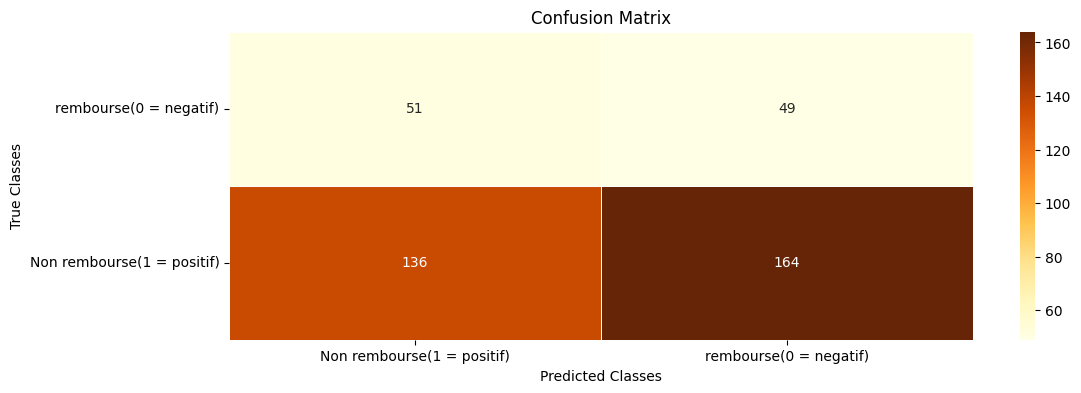

Successfully registered model 'CreditModels'.
2023/07/25 15:49:04 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 1
Created version '1' of model 'CreditModels'.


In [34]:
# Imbalanced data
model_metrics_dict['dummy_imbalance'] = dummy_model(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample)

Best params:
 <bound method BaseEstimator.get_params of DummyClassifier(strategy='uniform')>
Model score: 0.472
Time: 0.0
balanced_accuracy: 0.4716666666666667
f1: 0.31309904153354634
precision: 0.2300469483568075
recall: 0.49
roc_auc: 0.4716666666666667


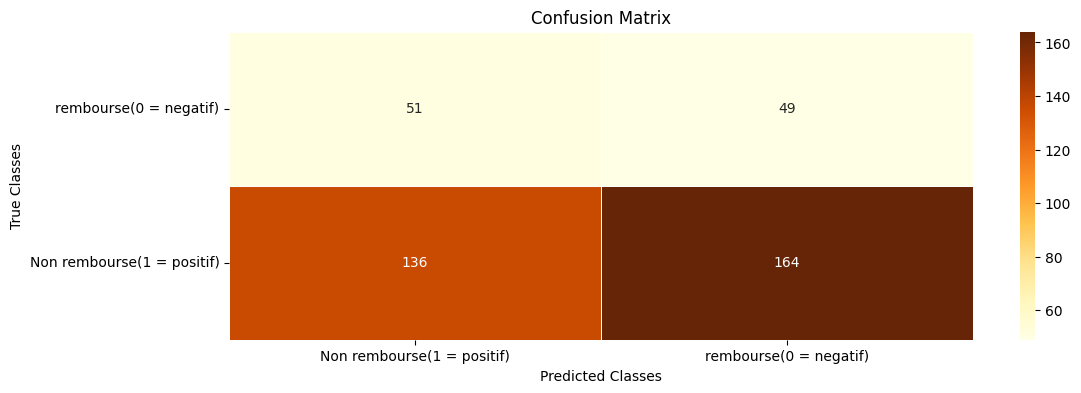

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/25 15:49:13 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 2
Created version '2' of model 'CreditModels'.


In [35]:
# Oversampling (SMOTE)
model_metrics_dict['dummy_oversample'] = dummy_model(X_train_sm, X_test_prepro, y_train_sm, y_test_sample)

Best params:
 <bound method BaseEstimator.get_params of DummyClassifier(strategy='uniform')>
Model score: 0.472
Time: 0.0
balanced_accuracy: 0.4716666666666667
f1: 0.31309904153354634
precision: 0.2300469483568075
recall: 0.49
roc_auc: 0.4716666666666667


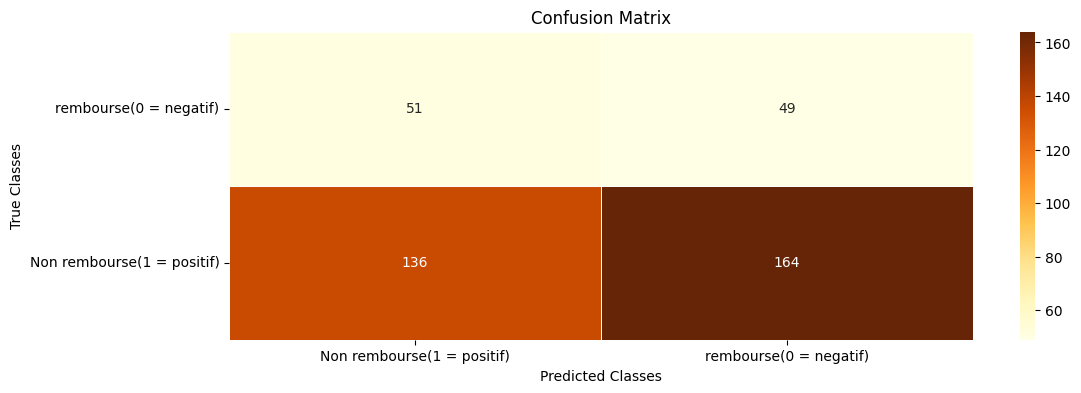

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/25 15:49:22 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 3
Created version '3' of model 'CreditModels'.


In [36]:
# Undersampling (RUS)
model_metrics_dict['dummy_undersample'] = dummy_model(X_train_rus, X_test_prepro, y_train_rus, y_test_sample)

In [37]:
def lr_model(X_train, X_test, y_train, y_test, use_class_weights=False):
    # Set the params for LogisticRegression
    param_grid_lr = [
        {'solver': ['lbfgs'],
         'C': np.logspace(.5, 7.5, 8),
         'penalty': ['none']
        }
    ]
    
    # Set the MLflow tracking URI
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    
    # Set the name of the experiment folder
    mlflow.set_experiment('LogReg Models')
    
    # Start counting time
    start_time = time.time()
    
    # Executed as a script
    if __name__ == "__main__":
        warnings.filterwarnings("ignore")
        np.random.seed(42)
        
        # Give the run a name
        with mlflow.start_run(run_name='logistic_regression/sample') as run:
            # Create an empty model
            if use_class_weights:
                lr_model = LogisticRegression(class_weight='balanced')
            else:
                lr_model = LogisticRegression()
            
            # Hyperparameter tuning
            grid_lr = GridSearchCV(estimator=lr_model,
                                   param_grid=param_grid_lr,
                                   return_train_score=True,
                                   error_score='raise',
                                   scoring=business_metric,
                                   cv=5)
            
            # Fit the model to the training data
            grid_lr.fit(X_train, y_train)
            
            # Display best params
            print("Best params:\n", grid_lr.best_params_)
            
            # Display model score
            print("Model score: %.3f" % grid_lr.score(X_test, y_test))
            
            # Calculate elapsed time
            elapsed_time = np.round(time.time() - start_time, 0)
            print("Time:", elapsed_time)
            
            # Predict classes with test data
            y_pred = grid_lr.predict(X_test)
            
            # Calculate and print evaluation metrics
            metrics = eval_metrics(y_test, y_pred)
            for name, score in metrics.items():
                print(f"{name}: {score}")
            
            # Plot heatmap of confusion matrix
            plot_heatmap_confusion(y_test, y_pred)
            
            # Plot AUC-ROC curve
            plot_auc_roc(y_test, grid_lr.predict_proba(X_test)[:, 1])
            
            # Store metrics into MLflow
            for name, score in metrics.items():
                mlflow.log_metric(name, score)
            
            # Store params into MLflow
            for k, v in grid_lr.best_params_.items():
                mlflow.log_param(k, v)
            
            # Check the type of storage
            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
            
            # Model registry does not work with file store
            if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(grid_lr, 'lr', registered_model_name="CreditModels")
            else:
                mlflow.sklearn.log_model(grid_lr, 'lr')

            metrics['business_metric'] = round(costs(y_test, y_pred),2)
            return metrics


2023/07/25 15:49:22 INFO mlflow.tracking.fluent: Experiment with name 'LogReg Models' does not exist. Creating a new experiment.


Best params:
 {'C': 3.1622776601683795, 'penalty': 'none', 'solver': 'lbfgs'}
Model score: 0.537
Time: 13.0
balanced_accuracy: 0.5983333333333334
f1: 0.39593908629441626
precision: 0.4020618556701031
recall: 0.39
roc_auc: 0.5983333333333333


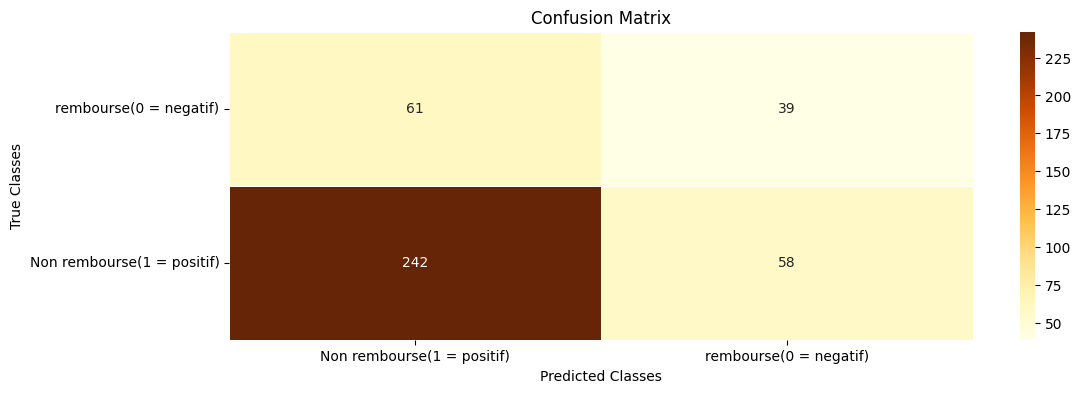

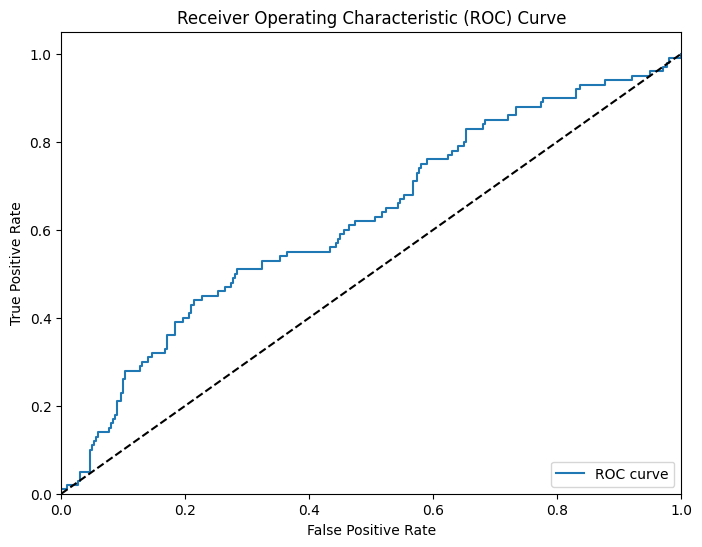

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/25 15:49:44 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 4
Created version '4' of model 'CreditModels'.


In [38]:
# Imbalanced data
model_metrics_dict['LR_imbalance'] = lr_model(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample)

Best params:
 {'C': 3.1622776601683795, 'penalty': 'none', 'solver': 'lbfgs'}
Model score: 0.578
Time: 17.0
balanced_accuracy: 0.615
f1: 0.4317180616740088
precision: 0.3858267716535433
recall: 0.49
roc_auc: 0.615


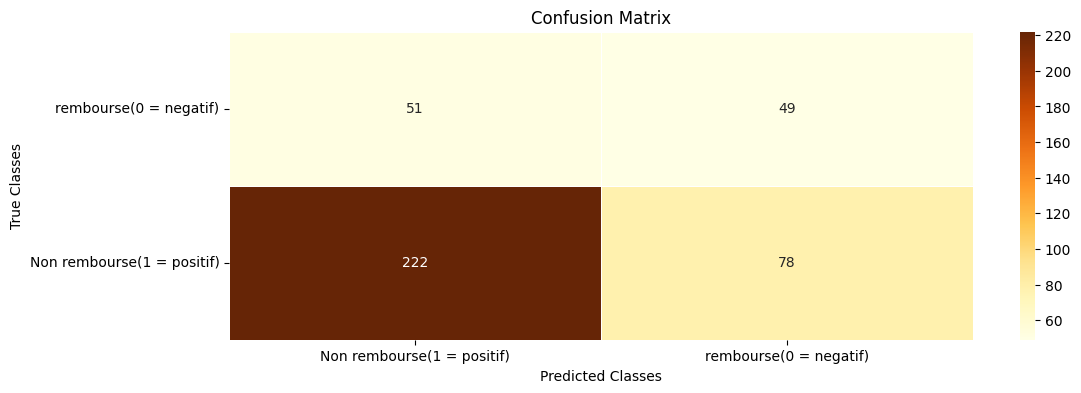

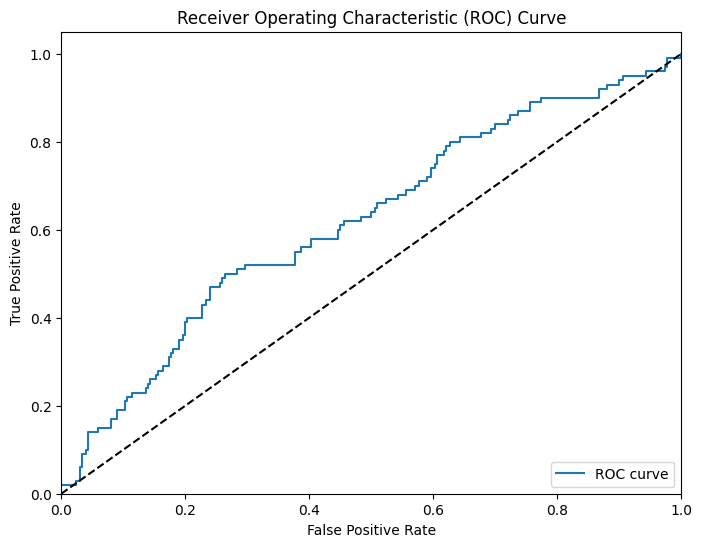

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/25 15:50:11 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 5
Created version '5' of model 'CreditModels'.


In [39]:
# Oversampling (SMOTE)
model_metrics_dict['LR_oversample'] = lr_model(X_train_sm, X_test_prepro, y_train_sm, y_test_sample)

Best params:
 {'C': 3.1622776601683795, 'penalty': 'none', 'solver': 'lbfgs'}
Model score: 0.584
Time: 8.0
balanced_accuracy: 0.5816666666666667
f1: 0.4111498257839721
precision: 0.3155080213903743
recall: 0.59
roc_auc: 0.5816666666666666


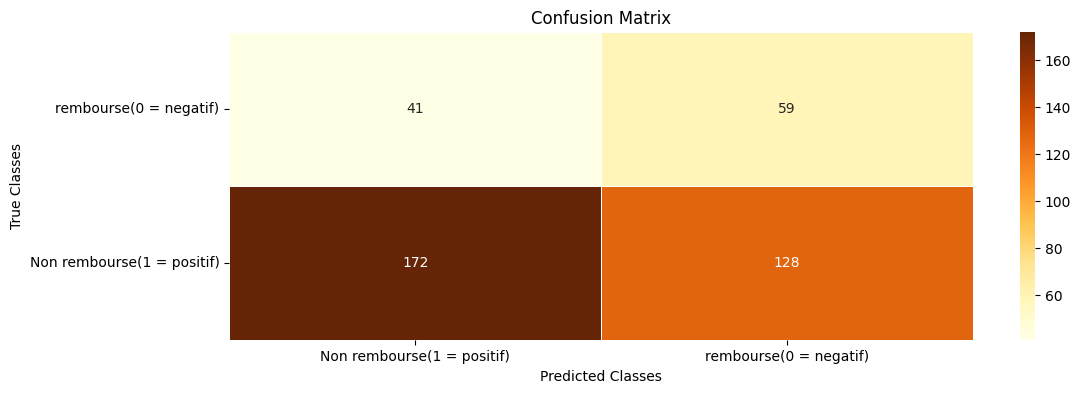

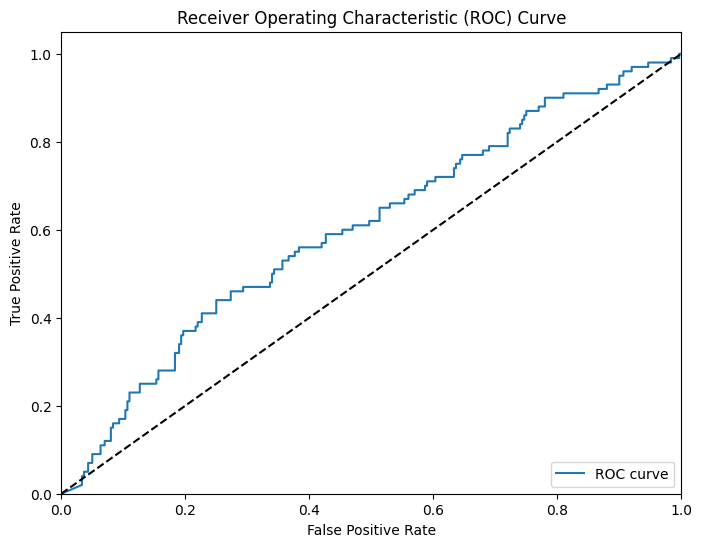

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/25 15:50:28 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 6
Created version '6' of model 'CreditModels'.


In [40]:
# Undersampling (RUS)
model_metrics_dict['LR_undersample'] = lr_model(X_train_rus, X_test_prepro, y_train_rus, y_test_sample)

Best params:
 {'C': 3.1622776601683795, 'penalty': 'none', 'solver': 'lbfgs'}
Model score: 0.583
Time: 13.0
balanced_accuracy: 0.6133333333333333
f1: 0.4322033898305085
precision: 0.375
recall: 0.51
roc_auc: 0.6133333333333334


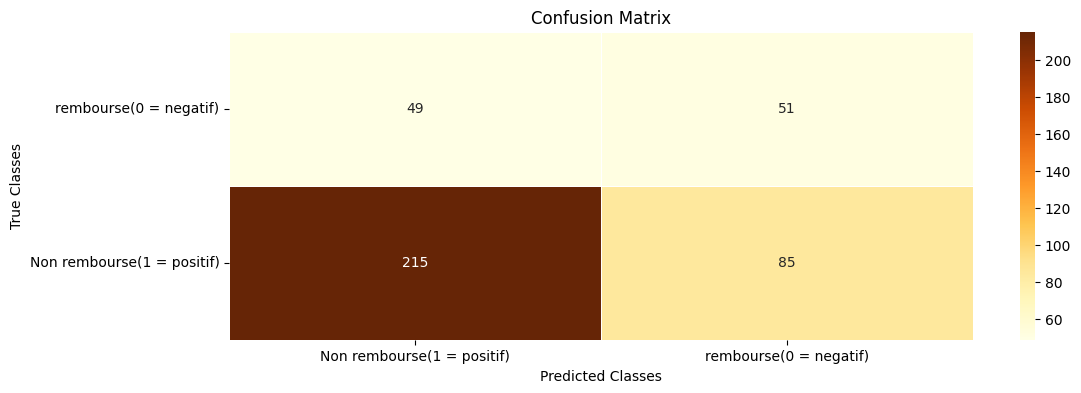

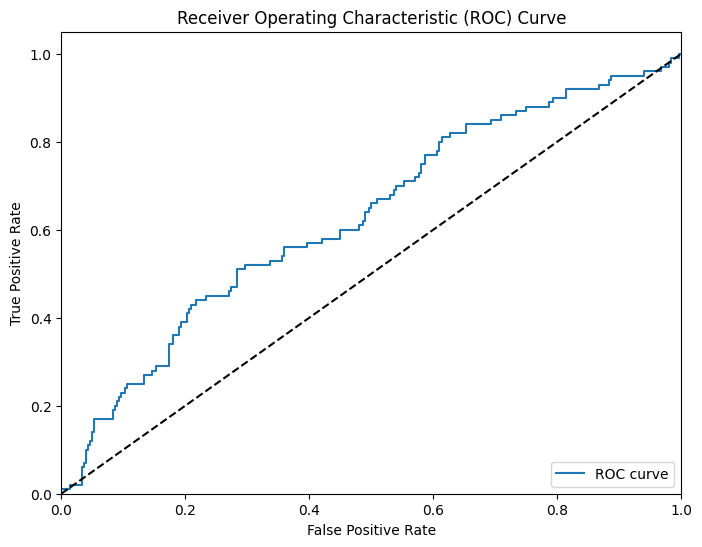

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/25 15:50:51 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 7
Created version '7' of model 'CreditModels'.


In [41]:
# class weight (balanced)
model_metrics_dict['LR_weighted'] = lr_model(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample, use_class_weights=True)

In [42]:
def knn_model(X_train, X_test, y_train, y_test, use_class_weights=False):
    name = 'knn'
    # Params for NearestNeighbors
    param_grid = [{'n_neighbors': list(range(1, 31))}]
    
    # Set the MLflow tracking URI
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    
    # Set the name of the experiment folder
    mlflow.set_experiment('KNeighbors Models')
    
    # Start counting time
    start_time = time.time()
    
    # Executed as a script
    if __name__ == "__main__":
        warnings.filterwarnings("ignore")
        np.random.seed(42)
        
        # Give the run a name
        with mlflow.start_run(run_name=name) as run:
            # Create an empty model
            if use_class_weights:
                knn_model = KNeighborsClassifier(weights='distance')
            else:
                knn_model = KNeighborsClassifier()
            
            # Hyperparameter tuning
            grid_knn = GridSearchCV(estimator=knn_model,
                                    param_grid=param_grid,
                                    return_train_score=True,
                                    error_score='raise',
                                    scoring=business_metric,
                                    cv=5)
            
            # Fit the model to the training data
            grid_knn.fit(X_train, y_train)
            
            # Display best params
            print("Best params:\n", grid_knn.best_params_)
            
            # Display model score
            print("Model score: %.3f" % grid_knn.score(X_test, y_test))
            
            # Calculate elapsed time
            elapsed_time = np.round(time.time() - start_time, 0)
            print("Time:", elapsed_time)
            
            # Predict classes with test data
            y_pred = grid_knn.predict(X_test)
            
            # Calculate and print evaluation metrics
            metrics = eval_metrics(y_test, y_pred)
            for name, score in metrics.items():
                print(f"{name}: {score}")
            
            # Plot heatmap of confusion matrix
            plot_heatmap_confusion(y_test, y_pred)
            
            # Plot AUC-ROC curve
            plot_auc_roc(y_test, grid_knn.predict_proba(X_test)[:, 1])
            
            # Store metrics into MLflow
            for name, score in metrics.items():
                mlflow.log_metric(name, score)
            
            # Store params into MLflow
            for k, v in grid_knn.best_params_.items():
                mlflow.log_param(k, v)
            
            # Check the type of storage
            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
            
            # Model registry does not work with file store
            if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(grid_knn, name, registered_model_name="CreditModels")
            else:
                mlflow.sklearn.log_model(grid_knn, name)

            metrics['business_metric'] = round(costs(y_test, y_pred),2)
            return metrics

2023/07/25 15:50:51 INFO mlflow.tracking.fluent: Experiment with name 'KNeighbors Models' does not exist. Creating a new experiment.


Best params:
 {'n_neighbors': 3}
Model score: 0.424
Time: 45.0
balanced_accuracy: 0.5216666666666667
f1: 0.2331288343558282
precision: 0.30158730158730157
recall: 0.19
roc_auc: 0.5216666666666666


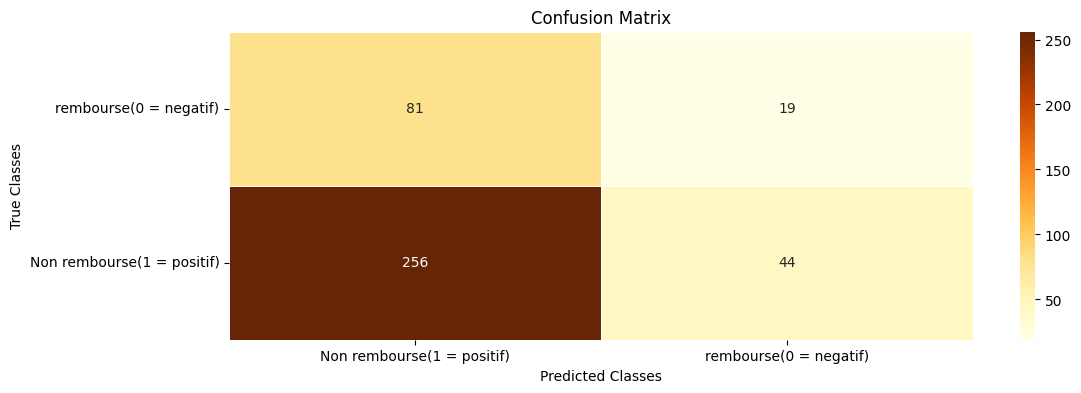

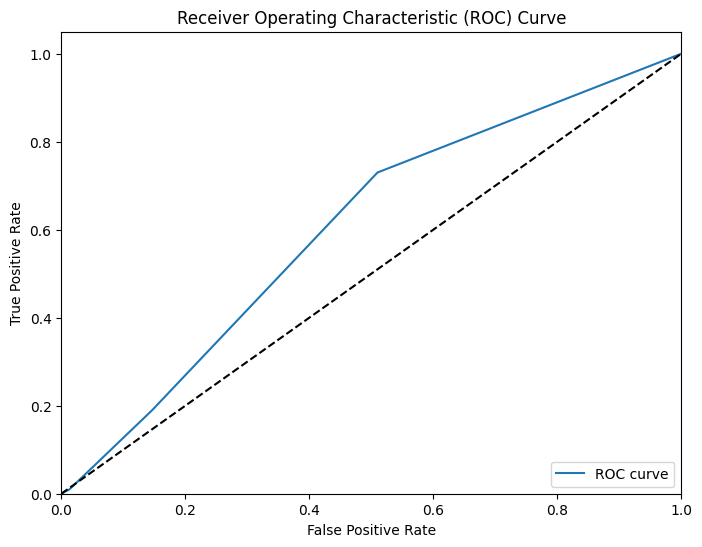

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/25 15:51:46 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 8
Created version '8' of model 'CreditModels'.


In [43]:
# Imbalanced data
model_metrics_dict['KNN_imbalance'] = knn_model(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample)

Best params:
 {'n_neighbors': 1}
Model score: 0.574
Time: 81.0
balanced_accuracy: 0.5466666666666666
f1: 0.39024390243902435
precision: 0.2807017543859649
recall: 0.64
roc_auc: 0.5466666666666667


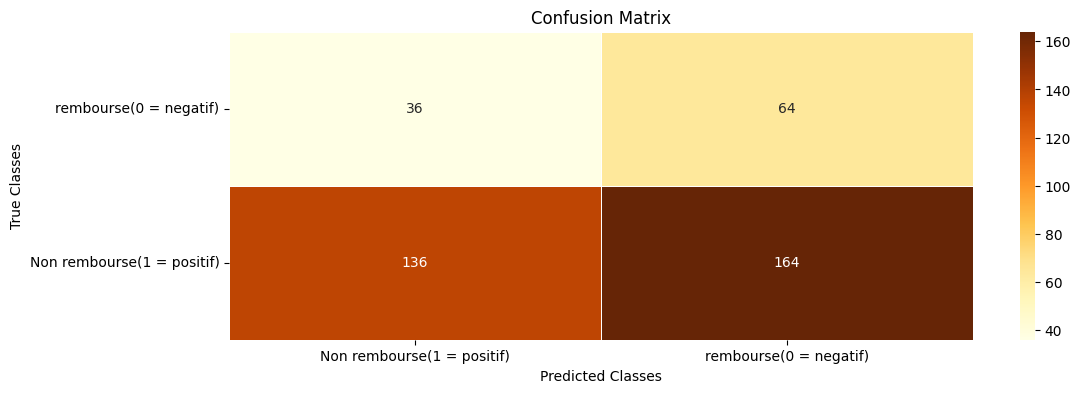

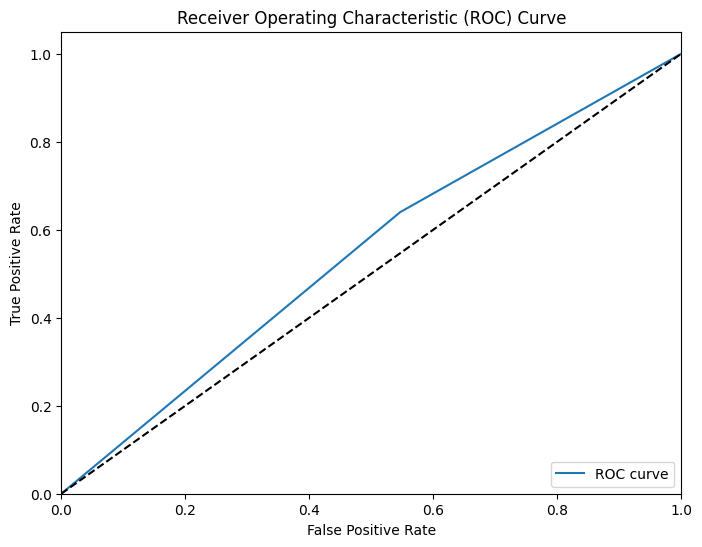

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/25 15:53:16 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 9
Created version '9' of model 'CreditModels'.


In [44]:
# Oversampling (SMOTE)
model_metrics_dict['KNN_oversample'] = knn_model(X_train_sm, X_test_prepro, y_train_sm, y_test_sample)

Best params:
 {'n_neighbors': 11}
Model score: 0.578
Time: 21.0
balanced_accuracy: 0.6066666666666667
f1: 0.42499999999999993
precision: 0.36428571428571427
recall: 0.51
roc_auc: 0.6066666666666667


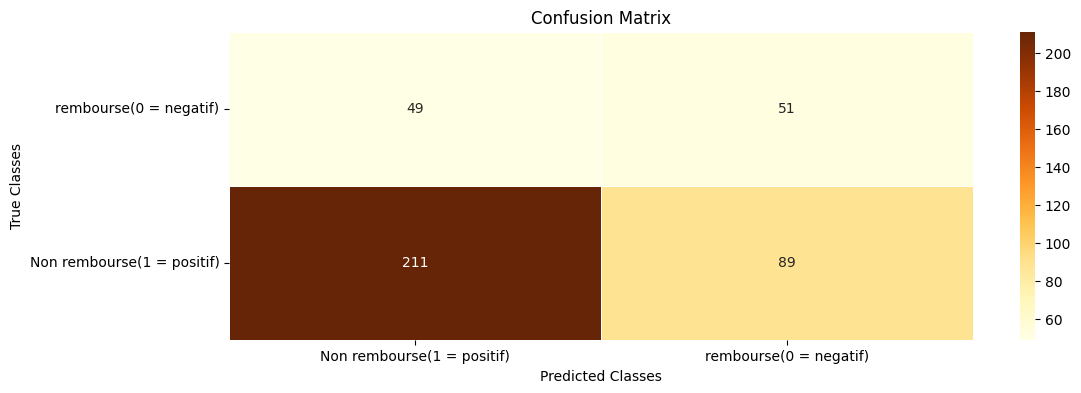

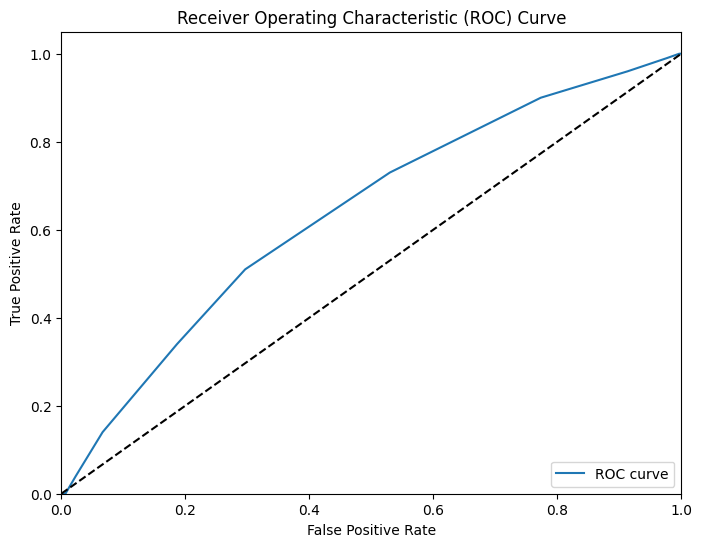

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/25 15:53:47 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 10
Created version '10' of model 'CreditModels'.


In [45]:
# Undersampling (RUS)
model_metrics_dict['KNN_undersample'] = knn_model(X_train_rus, X_test_prepro, y_train_rus, y_test_sample)

Best params:
 {'n_neighbors': 4}
Model score: 0.442
Time: 30.0
balanced_accuracy: 0.5383333333333333
f1: 0.2608695652173913
precision: 0.3442622950819672
recall: 0.21
roc_auc: 0.5383333333333333


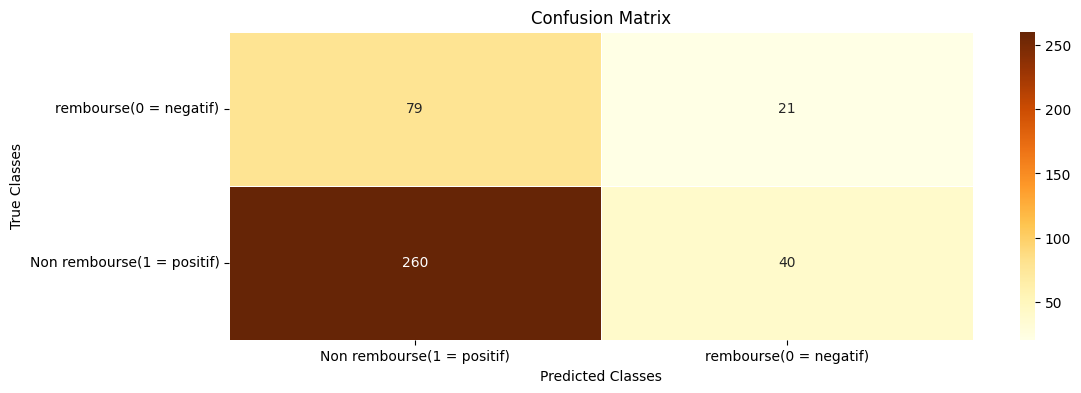

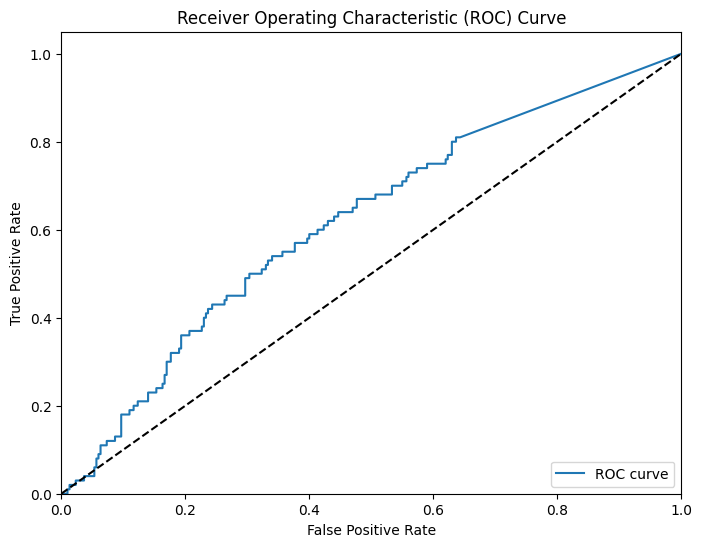

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/25 15:54:27 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 11
Created version '11' of model 'CreditModels'.


In [46]:
# class weight (balanced)
model_metrics_dict['KNN_weighted'] = knn_model(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample, use_class_weights=True)

In [47]:
def dt_model(X_train, X_test, y_train, y_test, use_class_weights=False):
    name = 'dt'
    # Params for DecisionTreeClassifier
    param_grid = [{'max_depth': [5, 10, None],
                   'min_samples_split': [2, 5, 10]}]
    
    # Set the MLflow tracking URI
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    
    # Set the name of the experiment folder
    mlflow.set_experiment('DecisionTree Models')
    
    # Start counting time
    start_time = time.time()
    
    # Executed as a script
    if __name__ == "__main__":
        warnings.filterwarnings("ignore")
        np.random.seed(42)
        
        # Give the run a name
        with mlflow.start_run(run_name=name) as run:
            # Create an empty model
            if use_class_weights:
                dt_model = DecisionTreeClassifier(class_weight='balanced')
            else:
                dt_model = DecisionTreeClassifier()
            
            # Hyperparameter tuning
            grid_dt = GridSearchCV(estimator=dt_model,
                                param_grid=param_grid,
                                return_train_score=True,
                                error_score='raise',
                                scoring=business_metric,
                                cv=5)
            
            # Fit the model to the training data
            grid_dt.fit(X_train, y_train)
            
            # Display best params
            print("Best params:\n", grid_dt.best_params_)
            
            # Display model score
            print("Model score: %.3f" % grid_dt.score(X_test, y_test))
            
            # Calculate elapsed time
            elapsed_time = np.round(time.time() - start_time, 0)
            print("Time:", elapsed_time)
            
            # Predict classes with test data
            y_pred = grid_dt.predict(X_test)
            
            # Calculate and print evaluation metrics
            metrics = eval_metrics(y_test, y_pred)
            for name, score in metrics.items():
                print(f"{name}: {score}")
            
            # Plot heatmap of confusion matrix
            plot_heatmap_confusion(y_test, y_pred)
            
            # Plot AUC-ROC curve
            plot_auc_roc(y_test, grid_dt.predict_proba(X_test)[:, 1])
            
            # Store metrics into MLflow
            for name, score in metrics.items():
                mlflow.log_metric(name, score)
            
            # Store params into MLflow
            for k, v in grid_dt.best_params_.items():
                mlflow.log_param(k, v)
            
            # Check the type of storage
            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
            
            # Model registry does not work with file store
            if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(grid_dt, name, registered_model_name="CreditModels")
            else:
                mlflow.sklearn.log_model(grid_dt, name)
                
            metrics['business_metric'] = round(costs(y_test, y_pred),2)
            return metrics


2023/07/25 15:54:27 INFO mlflow.tracking.fluent: Experiment with name 'DecisionTree Models' does not exist. Creating a new experiment.


Best params:
 {'max_depth': 5, 'min_samples_split': 10}
Model score: 0.446
Time: 18.0
balanced_accuracy: 0.5533333333333333
f1: 0.2638888888888889
precision: 0.4318181818181818
recall: 0.19
roc_auc: 0.5533333333333333


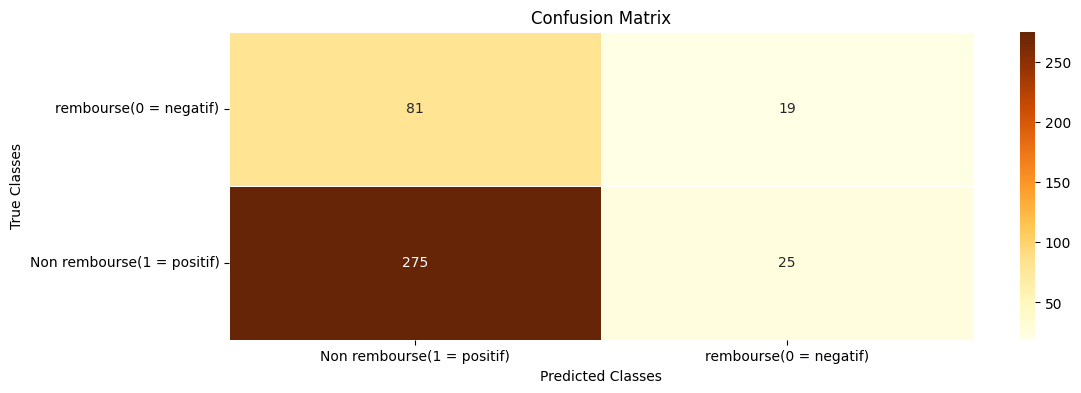

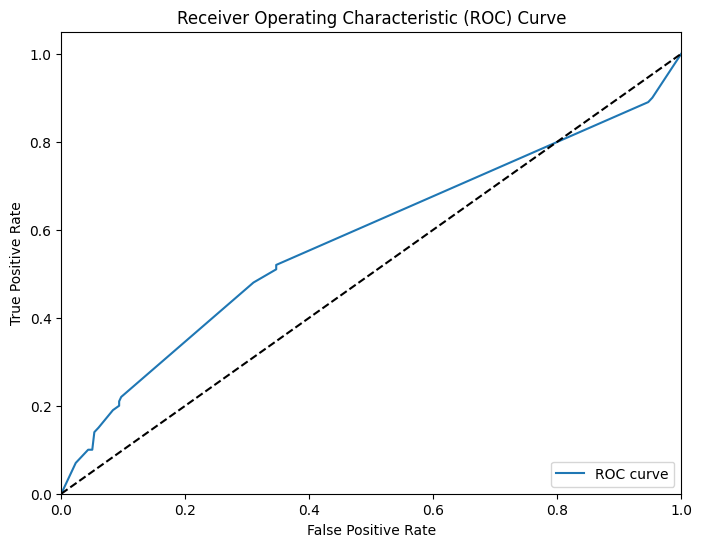

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/25 15:54:54 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 12
Created version '12' of model 'CreditModels'.


In [48]:
# Imbalanced data
model_metrics_dict['DT_imbalance'] = dt_model(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample) 

Best params:
 {'max_depth': None, 'min_samples_split': 2}
Model score: 0.479
Time: 28.0
balanced_accuracy: 0.5416666666666666
f1: 0.3188405797101449
precision: 0.308411214953271
recall: 0.33
roc_auc: 0.5416666666666666


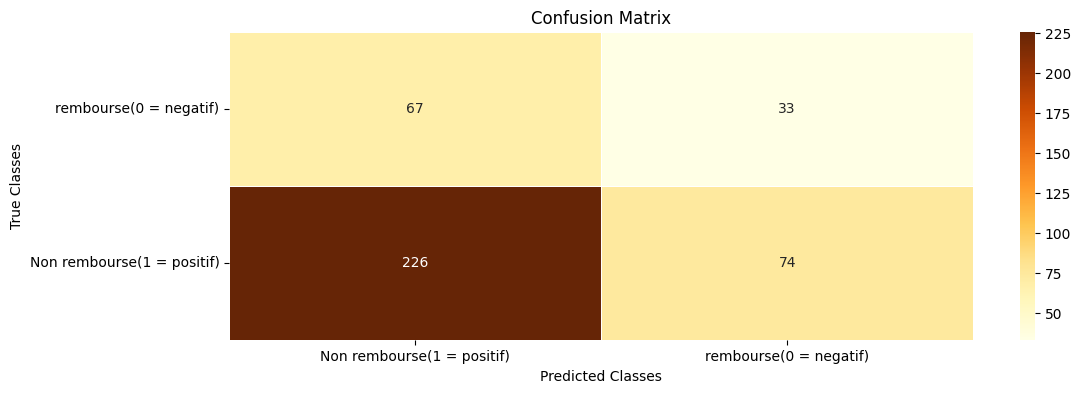

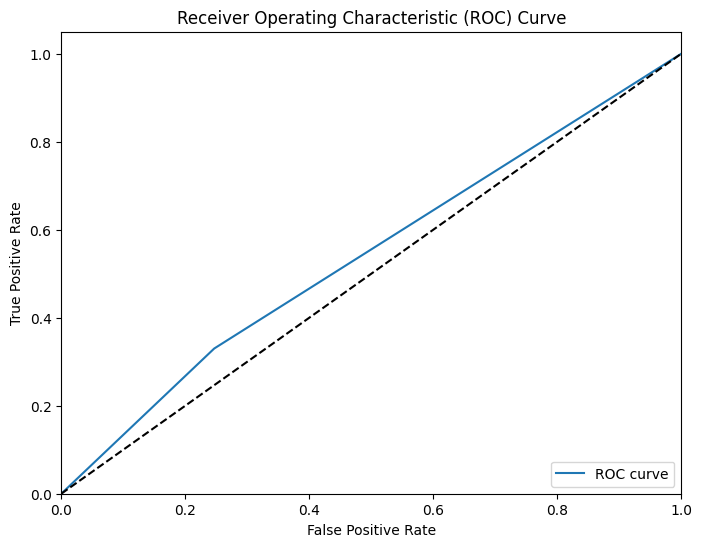

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/25 15:55:32 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 13
Created version '13' of model 'CreditModels'.


In [49]:
# Oversampling (SMOTE)
model_metrics_dict['DT_oversample'] = dt_model(X_train_sm, X_test_prepro, y_train_sm, y_test_sample)

Best params:
 {'max_depth': 5, 'min_samples_split': 5}
Model score: 0.579
Time: 8.0
balanced_accuracy: 0.6116666666666667
f1: 0.4291845493562232
precision: 0.37593984962406013
recall: 0.5
roc_auc: 0.6116666666666667


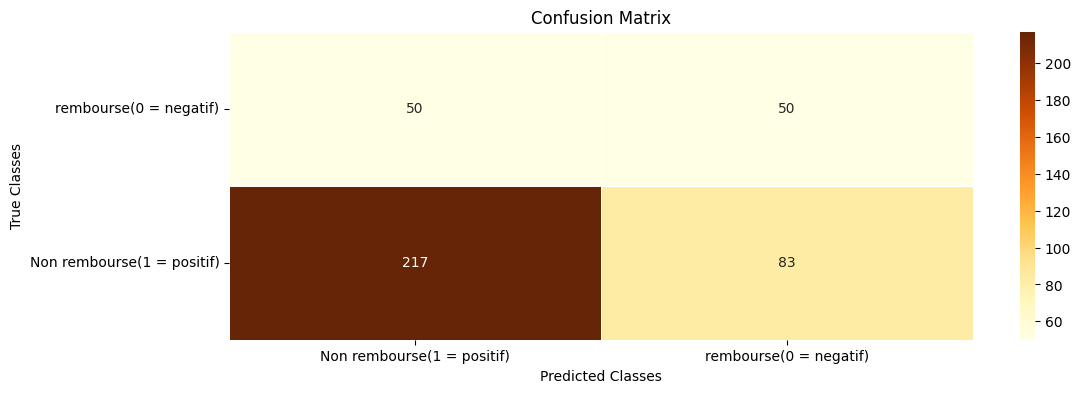

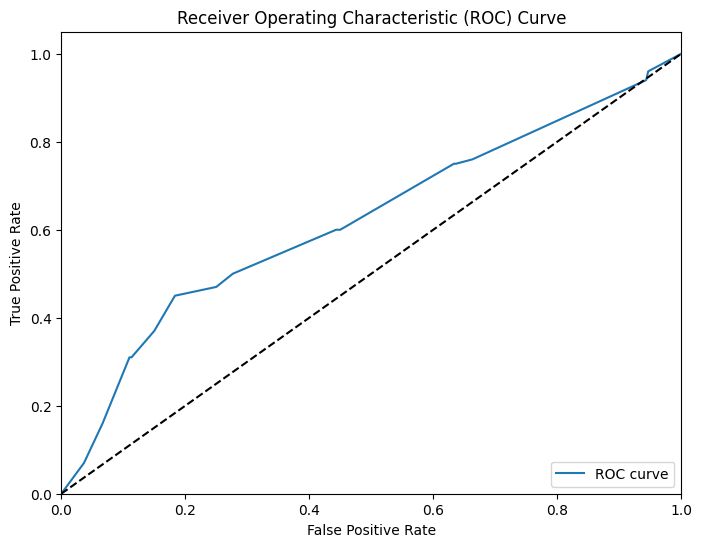

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/25 15:55:51 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 14
Created version '14' of model 'CreditModels'.


In [50]:
# Undersampling (RUS)
model_metrics_dict['DT_undersample'] = dt_model(X_train_rus, X_test_prepro, y_train_rus, y_test_sample)

Best params:
 {'max_depth': 5, 'min_samples_split': 2}
Model score: 0.551
Time: 16.0
balanced_accuracy: 0.5683333333333334
f1: 0.3878326996197719
precision: 0.3128834355828221
recall: 0.51
roc_auc: 0.5683333333333334


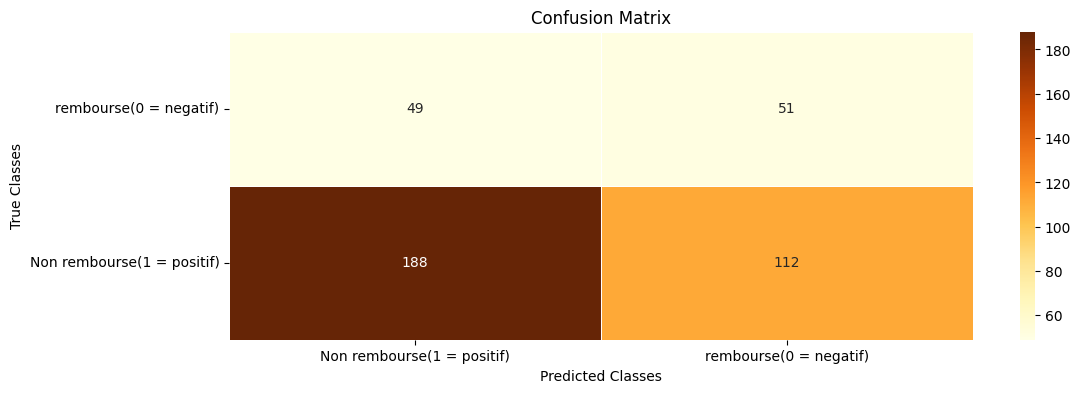

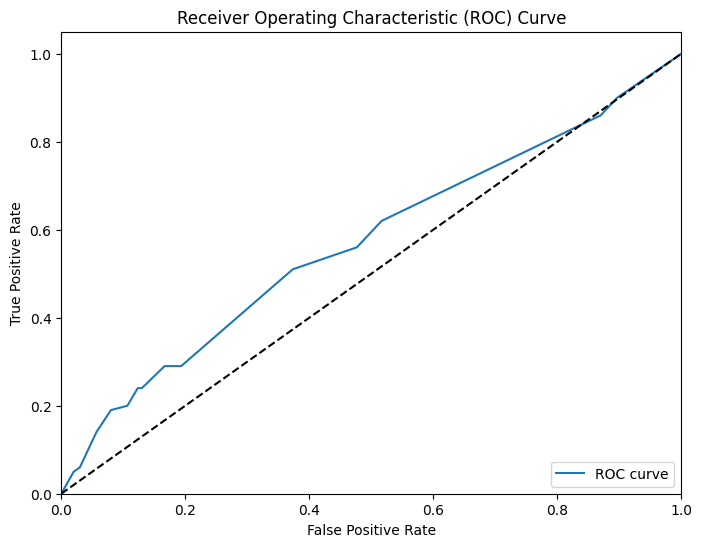

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/25 15:56:16 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 15
Created version '15' of model 'CreditModels'.


In [51]:
 # class weight (balanced)
model_metrics_dict['DT_weighted'] = dt_model(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample, use_class_weights=True) 

In [52]:
def rf_model(X_train, X_test, y_train, y_test, use_class_weights=False):
    name = 'rf'
    # Params for RandomForestClassifier
    param_grid = [{'n_estimators': [50, 100],
                   'max_depth': [7, 9],
                   'min_samples_split': [10, 11]}]
    
    # Set the MLflow tracking URI
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    
    # Set the name of the experiment folder
    mlflow.set_experiment('RandomF Models')
    
    # Start counting time
    start_time = time.time()
    
    # Executed as a script
    if __name__ == "__main__":
        warnings.filterwarnings("ignore")
        np.random.seed(42)
        
        # Give the run a name
        with mlflow.start_run(run_name=name) as run:
            # Create an empty model
            if use_class_weights:
                rf_model = RandomForestClassifier(class_weight='balanced')
            else:
                rf_model = RandomForestClassifier()
            
            # Hyperparameter tuning
            grid_rf = GridSearchCV(estimator=rf_model,
                                param_grid=param_grid,
                                return_train_score=True,
                                error_score='raise',
                                scoring=business_metric,
                                cv=5)
            
            # Fit the model to the training data
            grid_rf.fit(X_train, y_train)
            
            # Display best params
            print("Best params:\n", grid_rf.best_params_)
            
            # Display model score
            print("Model score: %.3f" % grid_rf.score(X_test, y_test))
            
            # Calculate elapsed time
            elapsed_time = np.round(time.time() - start_time, 0)
            print("Time:", elapsed_time)
            
            # Predict classes with test data
            y_pred = grid_rf.predict(X_test)
            
            # Calculate and print evaluation metrics
            metrics = eval_metrics(y_test, y_pred)
            for name, score in metrics.items():
                print(f"{name}: {score}")
            
            # Plot heatmap of confusion matrix
            plot_heatmap_confusion(y_test, y_pred)
            
            # Plot AUC-ROC curve
            plot_auc_roc(y_test, grid_rf.predict_proba(X_test)[:, 1])
            
            # Store metrics into MLflow
            for name, score in metrics.items():
                mlflow.log_metric(name, score)
            
            # Store params into MLflow
            for k, v in grid_rf.best_params_.items():
                mlflow.log_param(k, v)
            
            # Check the type of storage
            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
            
            # Model registry does not work with file store
            if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(grid_rf, name, registered_model_name="CreditModels")
            else:
                mlflow.sklearn.log_model(grid_rf, name)
                
            metrics['business_metric'] = round(costs(y_test, y_pred),2)
            return metrics


2023/07/25 15:56:16 INFO mlflow.tracking.fluent: Experiment with name 'RandomF Models' does not exist. Creating a new experiment.


Best params:
 {'max_depth': 9, 'min_samples_split': 11, 'n_estimators': 50}
Model score: 0.375
Time: 39.0
balanced_accuracy: 0.515
f1: 0.07476635514018691
precision: 0.5714285714285714
recall: 0.04
roc_auc: 0.515


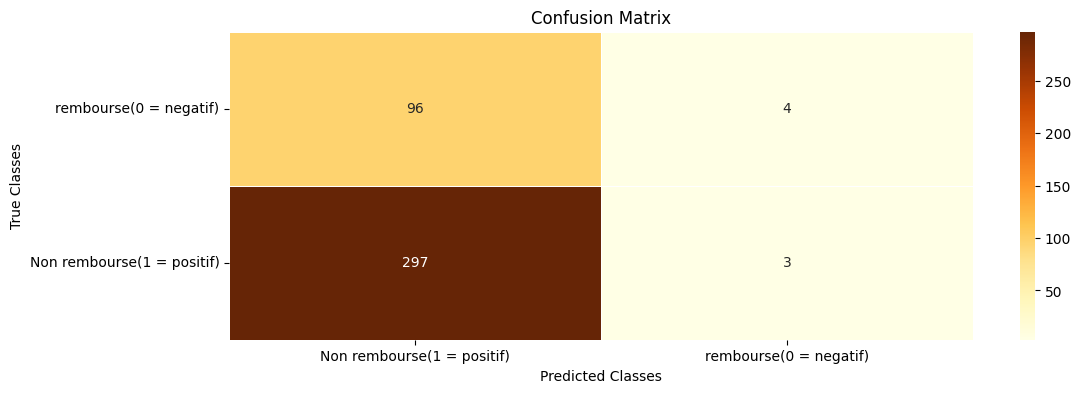

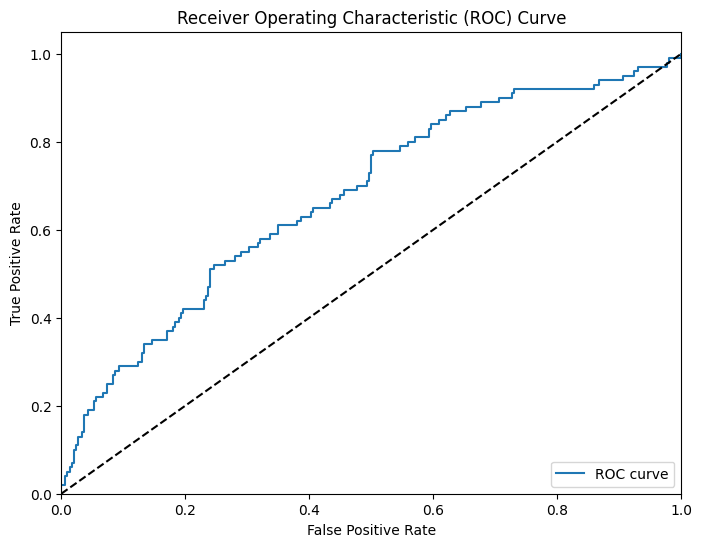

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/25 15:57:05 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 16
Created version '16' of model 'CreditModels'.


In [53]:
# Imbalanced data
model_metrics_dict['RF_imbalance'] = rf_model(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample)

Best params:
 {'max_depth': 9, 'min_samples_split': 10, 'n_estimators': 50}
Model score: 0.508
Time: 58.0
balanced_accuracy: 0.595
f1: 0.3680981595092025
precision: 0.47619047619047616
recall: 0.3
roc_auc: 0.595


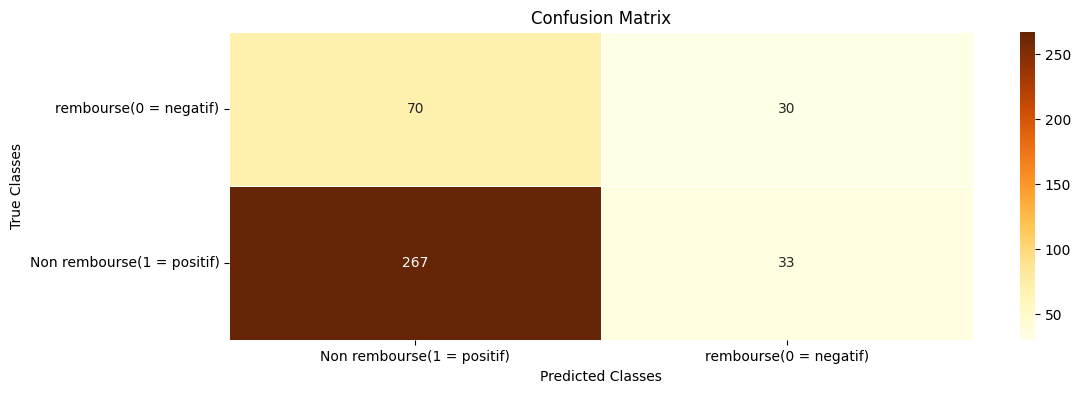

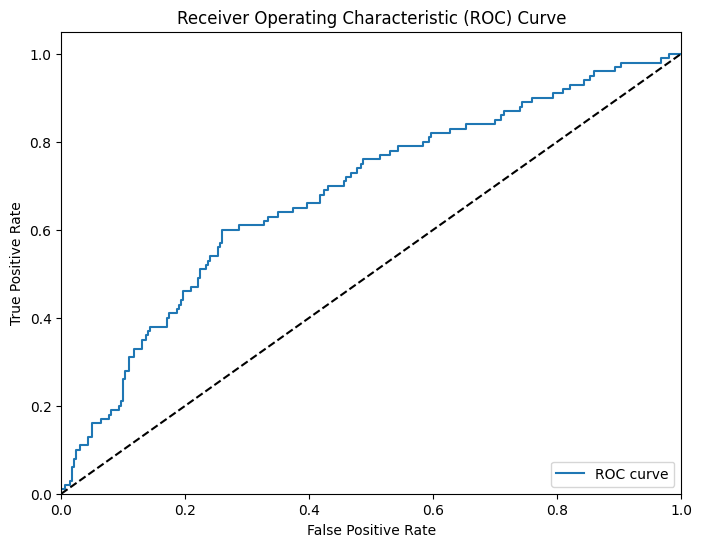

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/25 15:58:12 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 17
Created version '17' of model 'CreditModels'.


In [54]:
# Oversampling (SMOTE)
model_metrics_dict['RF_oversample'] = rf_model(X_train_sm, X_test_prepro, y_train_sm, y_test_sample)

Best params:
 {'max_depth': 9, 'min_samples_split': 10, 'n_estimators': 100}
Model score: 0.646
Time: 24.0
balanced_accuracy: 0.645
f1: 0.4761904761904762
precision: 0.37572254335260113
recall: 0.65
roc_auc: 0.645


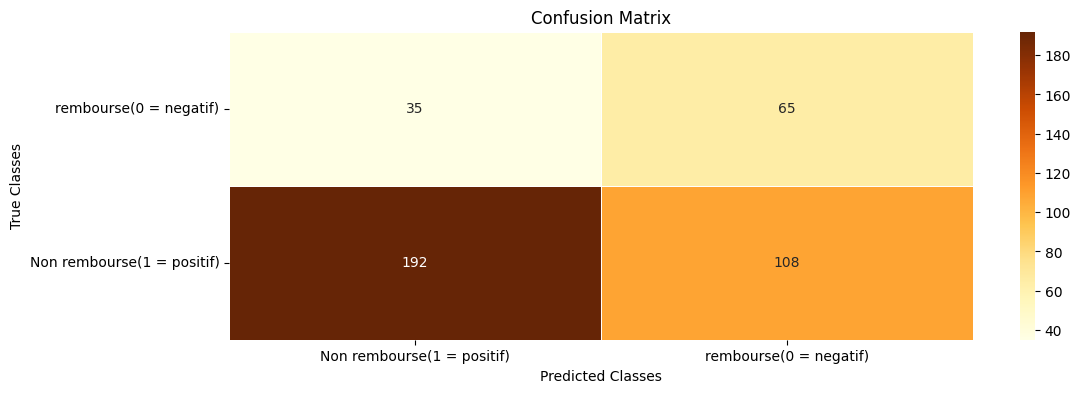

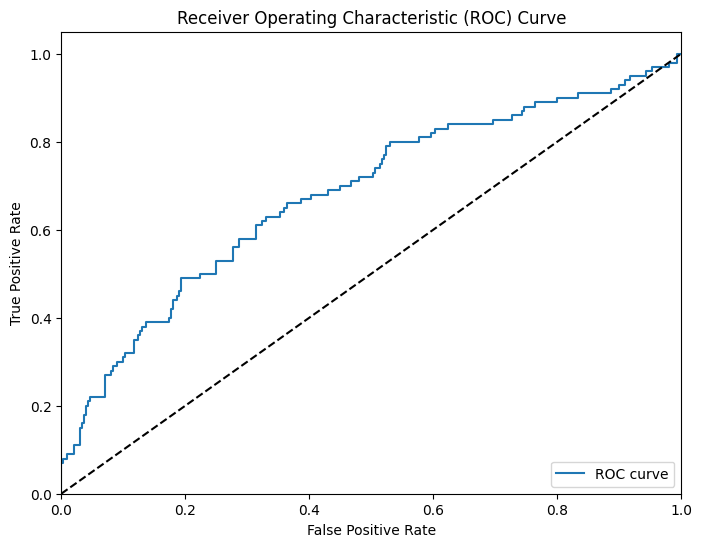

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/25 15:58:46 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 18
Created version '18' of model 'CreditModels'.


In [55]:
# Undersampling (RUS)
model_metrics_dict['RF_undersample'] = rf_model(X_train_rus, X_test_prepro, y_train_rus, y_test_sample)

Best params:
 {'max_depth': 7, 'min_samples_split': 11, 'n_estimators': 100}
Model score: 0.568
Time: 39.0
balanced_accuracy: 0.6416666666666666
f1: 0.45614035087719296
precision: 0.5492957746478874
recall: 0.39
roc_auc: 0.6416666666666667


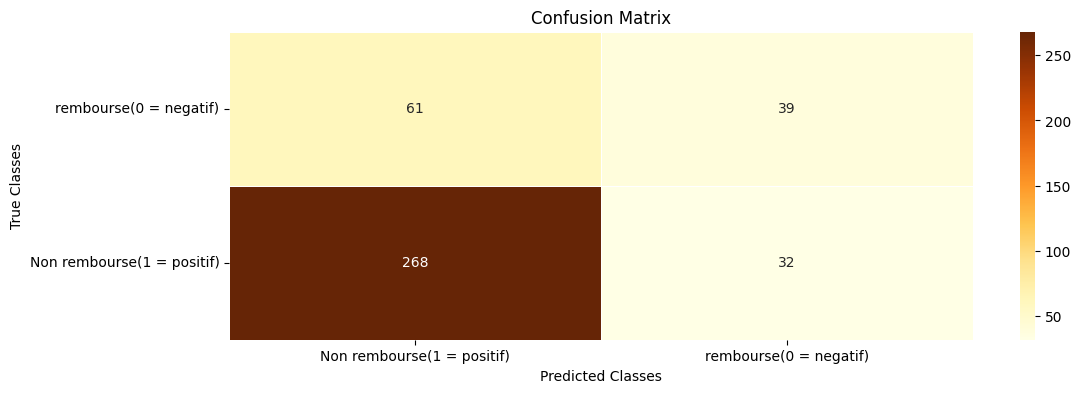

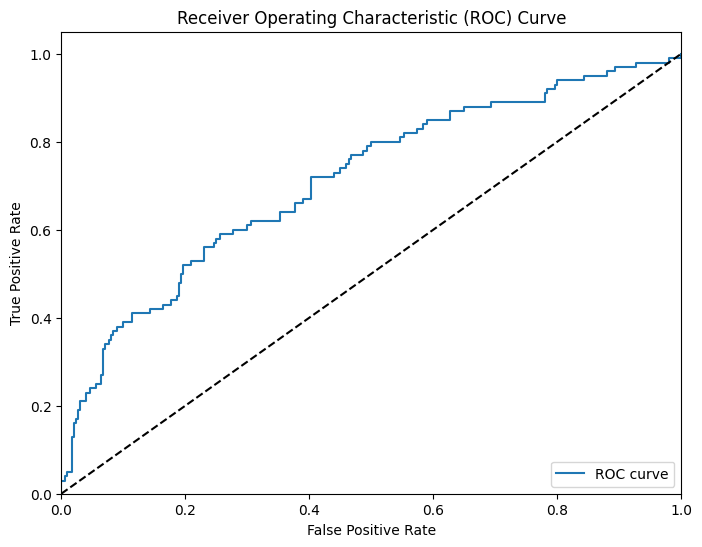

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/25 15:59:34 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 19
Created version '19' of model 'CreditModels'.


In [56]:
 # class weight (balanced)
model_metrics_dict['RT_weighted'] = rf_model(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample, use_class_weights=True)  

In [57]:
def xgb_model(X_train, X_test, y_train, y_test, use_class_weights=False):
    name = 'xgb'
    # Params for XGBClassifier
    param_grid = [{'n_estimators': [50, 100],
                   'max_depth': [3, 4, 5],
                   'learning_rate': [0.05, 0.04]}]
    
    # Set the MLflow tracking URI
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    
    # Set the name of the experiment folder
    mlflow.set_experiment('XGBoost Models')
    
    # Start counting time
    time1 = time.time()
    
    # Executed as a script
    if __name__ == "__main__":
        warnings.filterwarnings("ignore")
        np.random.seed(42)
        
        # Give the run a name
        with mlflow.start_run(run_name=name) as run:
            # Create an empty model
            xgb_model = XGBClassifier()
            
            # Hyperparameter tuning
            grid_xgb = GridSearchCV(estimator=xgb_model,
                                param_grid=param_grid,
                                return_train_score=True,
                                error_score='raise',
                                scoring=business_metric,
                                cv=5)
            
            # Fit the model to the training data
            if use_class_weights:
                classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
                grid_xgb.fit(X_train, y_train, sample_weight=classes_weights)
            else:
                grid_xgb.fit(X_train, y_train)
            
            # Display best params
            print("Best params:\n", grid_xgb.best_params_)
            
            # Display model score
            print("Model score: %.3f" % grid_xgb.score(X_test, y_test))
            
            # Calculate elapsed time
            time2 = np.round(time.time() - time1, 0)
            print("Time:", time2)
            
            # Predict classes with test data
            y_pred = grid_xgb.predict(X_test)
            
            # Calculate and print evaluation metrics
            metrics = eval_metrics(y_test, y_pred)
            for name, score in metrics.items():
                print(f"{name}: {score}")
            
            # Plot heatmap of confusion matrix
            plot_heatmap_confusion(y_test, y_pred)
            
            # Plot AUC-ROC curve
            plot_auc_roc(y_test, grid_xgb.predict_proba(X_test)[:, 1])
            
            # Store metrics into MLflow
            for name, score in metrics.items():
                mlflow.log_metric(name, score)
            
            # Store params into MLflow
            for k, v in grid_xgb.best_params_.items():
                mlflow.log_param(k, v)
            
            # Check the type of storage
            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
            
            # Model registry does not work with file store
            if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(grid_xgb, name, registered_model_name="CreditModels")
            else:
                mlflow.sklearn.log_model(grid_xgb, name)
                
            metrics['business_metric'] = round(costs(y_test, y_pred),2)
            return metrics


2023/07/25 15:59:34 INFO mlflow.tracking.fluent: Experiment with name 'XGBoost Models' does not exist. Creating a new experiment.


Best params:
 {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Model score: 0.479
Time: 102.0
balanced_accuracy: 0.5866666666666667
f1: 0.3235294117647059
precision: 0.6111111111111112
recall: 0.22
roc_auc: 0.5866666666666667


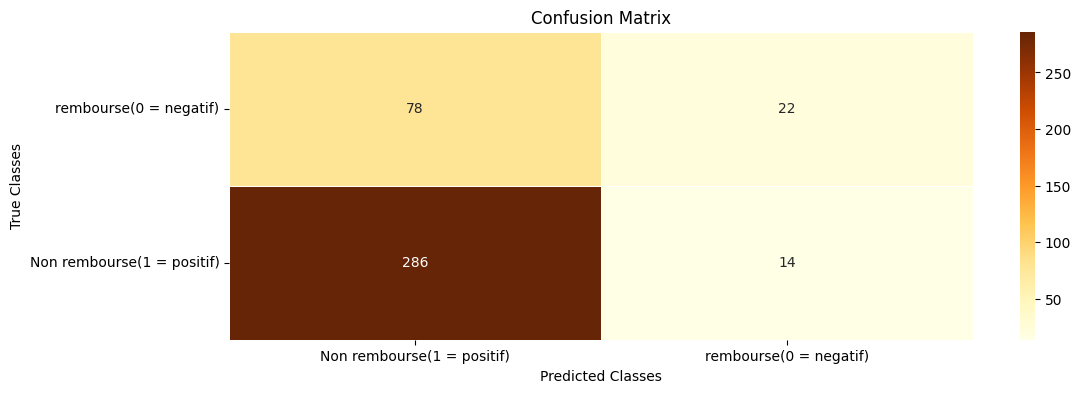

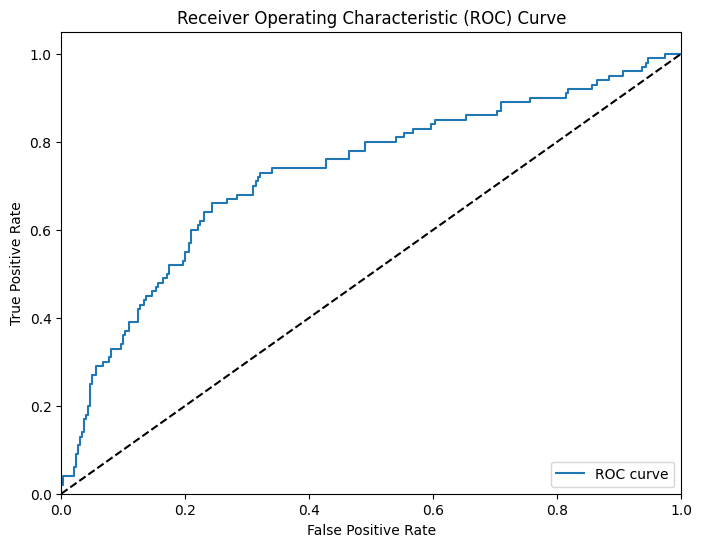

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/25 16:01:26 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 20
Created version '20' of model 'CreditModels'.


In [58]:
# Imbalanced data
model_metrics_dict['XGB_imbalance'] = xgb_model(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample)

Best params:
 {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Model score: 0.533
Time: 147.0
balanced_accuracy: 0.6216666666666667
f1: 0.41290322580645156
precision: 0.5818181818181818
recall: 0.32
roc_auc: 0.6216666666666667


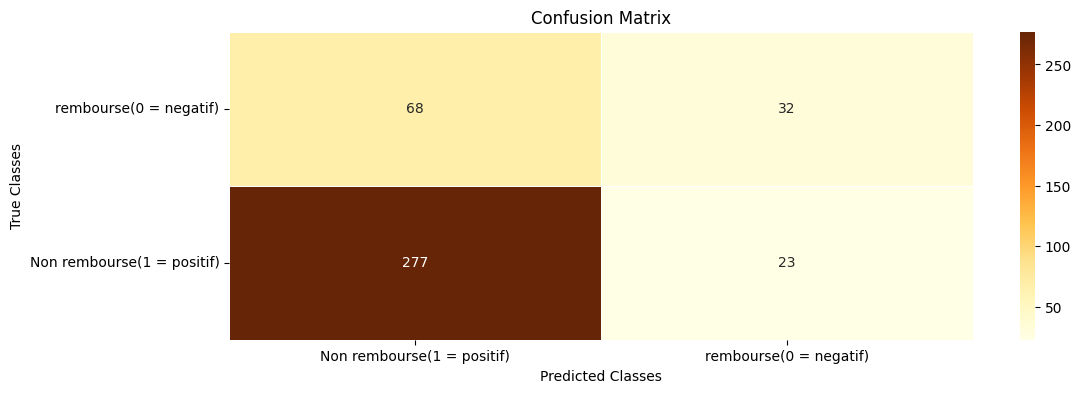

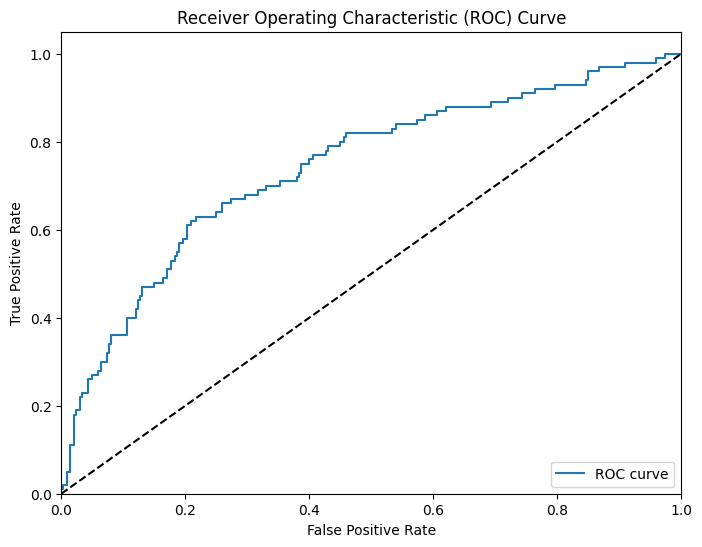

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/25 16:04:03 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 21
Created version '21' of model 'CreditModels'.


In [59]:
# Oversampling (SMOTE)
model_metrics_dict['XGB_oversample'] = xgb_model(X_train_sm, X_test_prepro, y_train_sm, y_test_sample)

Best params:
 {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}
Model score: 0.618
Time: 74.0
balanced_accuracy: 0.6383333333333333
f1: 0.46530612244897956
precision: 0.3931034482758621
recall: 0.57
roc_auc: 0.6383333333333333


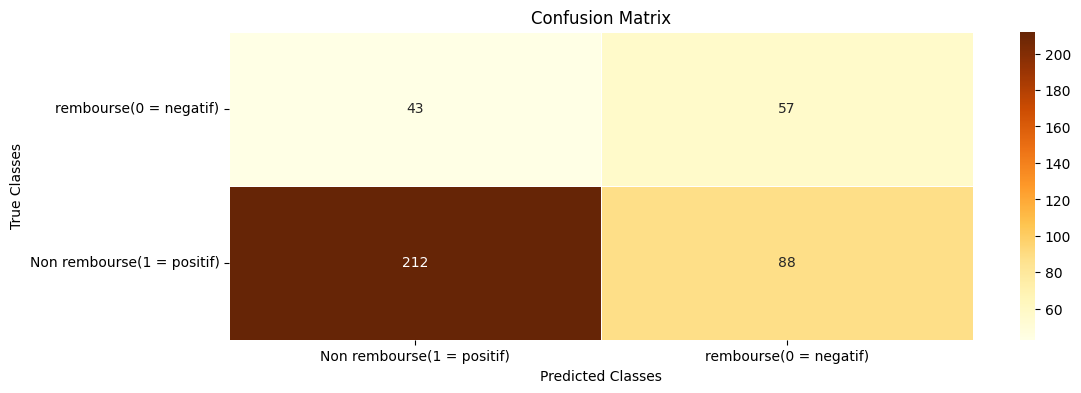

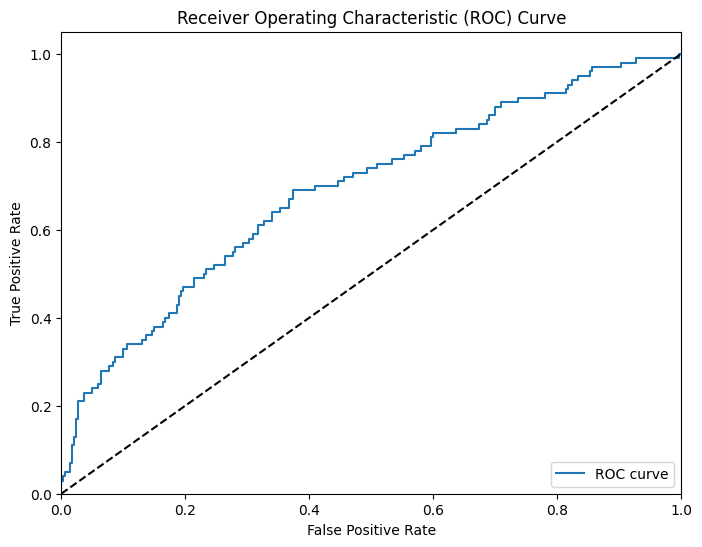

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/25 16:05:26 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 22
Created version '22' of model 'CreditModels'.


In [60]:
# Undersampling (RUS)
model_metrics_dict['XGB_undersample'] = xgb_model(X_train_rus, X_test_prepro, y_train_rus, y_test_sample)

Best params:
 {'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 50}
Model score: 0.612
Time: 102.0
balanced_accuracy: 0.65
f1: 0.47706422018348627
precision: 0.4406779661016949
recall: 0.52
roc_auc: 0.65


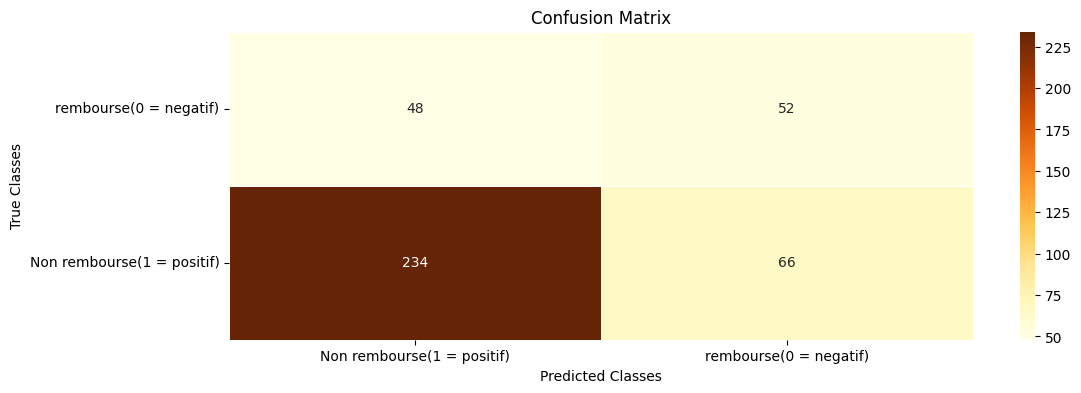

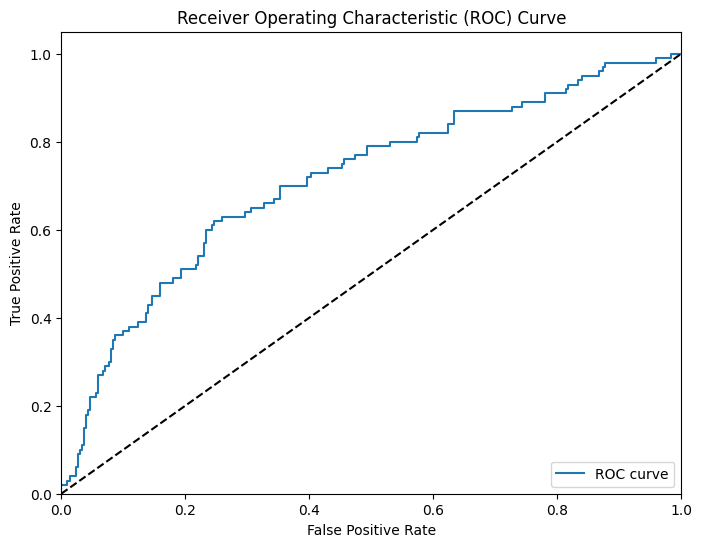

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/25 16:07:17 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 23
Created version '23' of model 'CreditModels'.


In [61]:
 # class weight (balanced)
model_metrics_dict['XGB_weighted'] = xgb_model(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample, use_class_weights=True)  

In [62]:
df_sample.shape

(2000, 429)

In [63]:
results = pd.DataFrame(columns=['model', 'balanced_accuracy', 'business_metric','roc_auc','precision','recall','f1'])

# Iterate over the dictionary items and append rows to the DataFrame
for model, values in model_metrics_dict.items():
    results = results.append({'model': model, 'balanced_accuracy': values['balanced_accuracy'], 'business_metric': values['business_metric'], 'roc_auc': values['roc_auc'], 'precision': values['precision'], 'recall': values['recall'], 'f1': values['f1']}, ignore_index=True)
results = results.sort_values(by=['business_metric','roc_auc'],ascending=False)
results

,model,balanced_accuracy,business_metric,roc_auc,precision,recall,f1
17,RF_undersample,0.645000,0.65,0.645000,0.375723,0.65,0.476190
21,XGB_undersample,0.638333,0.62,0.638333,0.393103,0.57,0.465306
22,XGB_weighted,0.650000,0.61,0.650000,0.440678,0.52,0.477064
4,LR_oversample,0.615000,0.58,0.615000,0.385827,0.49,0.431718
6,LR_weighted,0.613333,0.58,0.613333,0.375000,0.51,0.432203
13,DT_undersample,0.611667,0.58,0.611667,0.375940,0.50,0.429185
9,KNN_undersample,0.606667,0.58,0.606667,0.364286,0.51,0.425000
5,LR_undersample,0.581667,0.58,0.581667,0.315508,0.59,0.411150
18,RT_weighted,0.641667,0.57,0.641667,0.549296,0.39,0.456140
8,KNN_oversample,0.546667,0.57,0.546667,0.280702,0.64,0.390244


# Split classique

In [64]:
df_final_without_ID = pd.read_csv(os.path.join('..','data','df_final.csv'))
df_final_without_ID.sample(5)

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
232923,0.0,Cash loans,1,0,0,2,72000.0,198666.0,15696.0,175500.0,...,11559.575250,693574.515,3.915,90001.665,12714.759750,762885.585,-48.0,-1323.283333,-79397.0,60.0
263698,0.0,Cash loans,1,0,1,0,221400.0,247500.0,9814.5,247500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36463,0.0,Cash loans,0,0,1,0,360000.0,521136.0,54855.0,495000.0,...,4623.738750,55484.865,0.180,4630.680,3851.958750,46223.505,-752.0,-893.416667,-10721.0,12.0
279380,0.0,Cash loans,0,1,0,0,360000.0,824917.5,39816.0,724500.0,...,44156.157353,1501309.350,1116.180,45455.265,42819.237794,1455854.085,-4.0,-460.147059,-15645.0,34.0
148324,0.0,Cash loans,1,0,0,0,135000.0,628114.5,22689.0,477000.0,...,11926.170000,143114.040,11795.985,11938.005,11926.170000,143114.040,-1465.0,-1634.166667,-19610.0,12.0


In [65]:
df_final_without_ID.shape

(307507, 429)

In [66]:
X = df_final_without_ID.drop('TARGET',axis=1)
y = df_final_without_ID['TARGET']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,train_size=0.8)

In [68]:
X_train.shape,X_test.shape

((246005, 428), (61502, 428))

In [69]:
del df_final_without_ID

In [70]:
categorical_list_2 = []
numerical_list_2 = []

# Identify categorical and numerical columns
for i in X_train.columns.tolist():
    if X_train[i].dtype == 'object':
        categorical_list_2.append(i)
    else:
        numerical_list_2.append(i)

# Create and fit SimpleImputer on numerical columns
simple_imputer = SimpleImputer(strategy='median').fit(X_train[numerical_list_2])

# Infer signature for the imputer model
signature = infer_signature(X_train, y_train)

# Save the imputer model using MLflow
mlflow.sklearn.save_model(simple_imputer, 'imputer', signature=signature)

2023/07/25 16:08:57 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


# Modèle final

In [71]:
def model_xgb_final(X_train_, X_test_, y_train_, y_test_, use_class_weights=False):
    name = 'xgb_final'
    # Params for XGBClassifier
    param_grid = [{'n_estimators': [50, 100],
                   'max_depth': [3, 4, 5],
                   'learning_rate': [0.05, 0.04]}]
    
    # Set the MLflow tracking URI
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    
    # Set the name of the experiment folder
    mlflow.set_experiment('XGBoost Models')
    
    # Start counting time
    time1 = time.time()
    
    # Executed as a script
    if __name__ == "__main__":
        warnings.filterwarnings("ignore")
        np.random.seed(42)
        
        # Give the run a name
        with mlflow.start_run(run_name=name) as run:
            # Create an empty model
            cls = XGBClassifier()
            
            # Hyperparameter tuning
            grid = GridSearchCV(estimator=cls,
                                param_grid=param_grid,
                                return_train_score=True,
                                error_score='raise',
                                scoring=business_metric,
                                cv=5)
            
            # Fit the model to the training data
            if use_class_weights:
                classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train_)
                grid.fit(X_train_, y_train_, sample_weight=classes_weights)
            else:
                grid.fit(X_train_, y_train_)
            
            # Display best params
            print("Best params:\n", grid.best_params_)
            
            # Display model score
            print("Model score: %.3f" % grid.score(X_test_, y_test_))
            
            # Calculate elapsed time
            time2 = np.round(time.time() - time1, 0)
            print("Time:", time2)
            
            # Predict classes with test data
            y_pred = grid.predict(X_test_)
            
            # Calculate and print evaluation metrics
            eval_metrics(y_test_, y_pred)
            
            # Plot heatmap of confusion matrix
            plot_heatmap_confusion(y_test_, y_pred)
            
            # Plot AUC-ROC curve
            plot_auc_roc(y_test_, grid.predict_proba(X_test_)[:, 1])
            
            # Store metrics into MLflow
            metrics = eval_metrics(y_test_, y_pred)
            for k, v in metrics.items():
                mlflow.log_metric(k, v)
            
            # Store params into MLflow
            for k, v in grid.best_params_.items():
                mlflow.log_param(k, v)
            
            # Check the type of storage
            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
            
            # Model registry does not work with file store
            if tracking_url_type_store != "file":
                mlflow.sklearn.log_model(grid, name, registered_model_name="CreditModels")
            else:
                mlflow.sklearn.log_model(grid, name)
            return grid.best_params_

Best params:
 {'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 50}
Model score: 0.612
Time: 102.0
balanced_accuracy: 0.65
f1: 0.47706422018348627
precision: 0.4406779661016949
recall: 0.52
roc_auc: 0.65


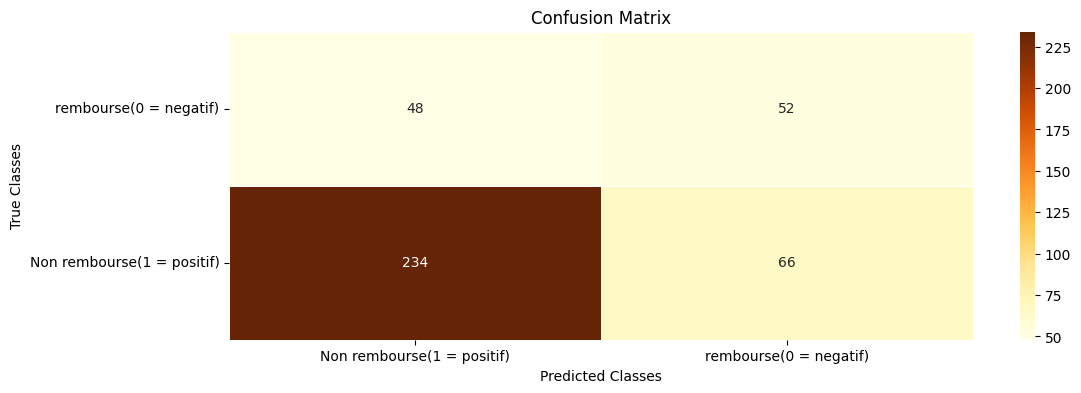

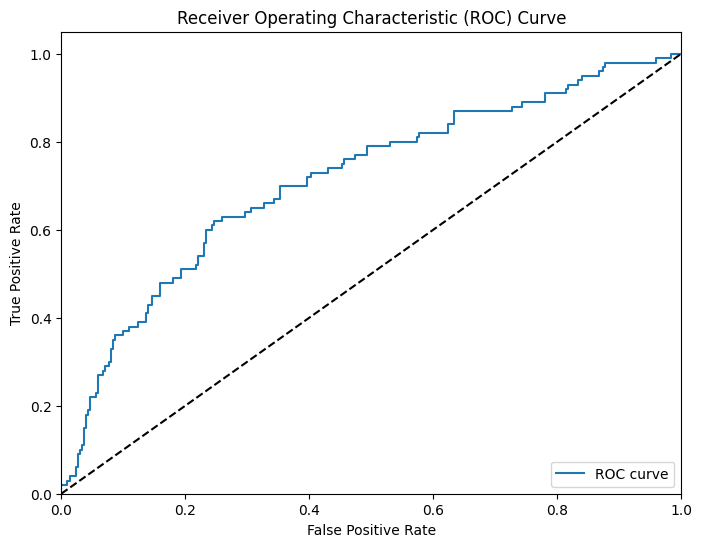

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/07/25 16:11:04 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: CreditModels, version 24
Created version '24' of model 'CreditModels'.


In [72]:
 # class weight (balanced)
best_params = xgb_model(X_train_prepro, X_test_prepro, y_train_sample, y_test_sample, use_class_weights=True)  

In [73]:
best_params

{'balanced_accuracy': 0.65,
 'f1': 0.47706422018348627,
 'precision': 0.4406779661016949,
 'recall': 0.52,
 'roc_auc': 0.65,
 'business_metric': 0.61}

# Préparation au déploiement

In [74]:
pipeline = Pipeline([('preprocessor', preprocessor), 
                     ('classifier', XGBClassifier(**best_params))])

In [75]:
# pipeline.fit(X_train_prepro,y_train_sample)
pipeline.fit(X_train,y_train)

[16:11:54] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "balanced_accuracy", "business_metric", "f1", "precision", "recall", "roc_auc" } are not used.



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELA

In [76]:
pipeline.predict(df_sample.drop(columns=['TARGET']))

array([0, 0, 0, ..., 1, 0, 0])

In [77]:
sample_data_file_path = os.path.join('..','data','sample_data.pkl')
data_to_export = df_sample.drop(columns=['TARGET'])
outfile = open(sample_data_file_path,'wb')
pickle.dump(data_to_export,outfile)
outfile.close()

In [78]:
model_file_path = os.path.join('..','data','model.pkl')
outfile = open(model_file_path,'wb')
pickle.dump(pipeline,outfile)
outfile.close()

# Définition du seuil

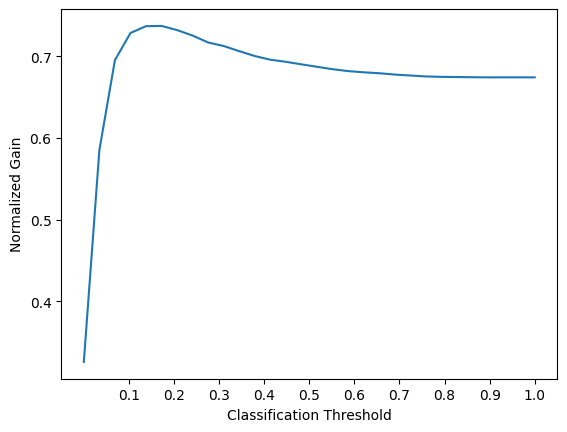

In [79]:
threshold_x = np.linspace(0.0, 1, 30)
cost_function = []

for threshold in threshold_x:
    # Calculate y_pred based on threshold
    y_scores = pipeline.predict_proba(X_test)[:, 1]
    y_pred = (y_scores > threshold).astype(int)
    
    # Calculate the custom_metric score
    cost_function.append(costs(y_test, y_pred))

# Plot the normalized gain
plt.plot(threshold_x, cost_function)
plt.xlabel("Classification Threshold")
plt.ylabel("Normalized Gain")
plt.xticks(np.linspace(0.1, 1, 10))
plt.show()

In [80]:
threshold = []
for thresh, cost in zip(threshold_x, cost_function):
    if cost == max(cost_function):
        threshold.append(thresh)

# Modify predictions using manual threshold adjustment
y_pred = pipeline.predict_proba(X_test)
y_pred = (y_pred[:, 1] >= threshold) * 1
threshold[0]

0.1724137931034483

In [81]:
name = 'xgb_threshold/' + str(threshold[0])

# Set the path where it is stored
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Set the name of the experiment folder
mlflow.set_experiment('XGBoost Models')

# Initialise counting time
time1 = time.time()

# Executed as a script
if __name__ == "__main__":
    warnings.filterwarnings("ignore")
    np.random.seed(42)
    # Give the run a name
    with mlflow.start_run(run_name=name) as run:
        
        # Return all metrics
        print('Scores après application du threshold :')
        for k, v in zip(eval_metrics(y_test, y_pred).keys(), eval_metrics(y_test, y_pred).values()):
            print('{} : {:.3f}'.format(k, v))
        print("score custom metric : %.3f" % costs(y_test, y_pred))
        
        time2 = np.round(time.time() - time1, 0)


Scores après application du threshold :
balanced_accuracy : 0.646
f1 : 0.316
precision : 0.268
recall : 0.385
roc_auc : 0.646
score custom metric : 0.737


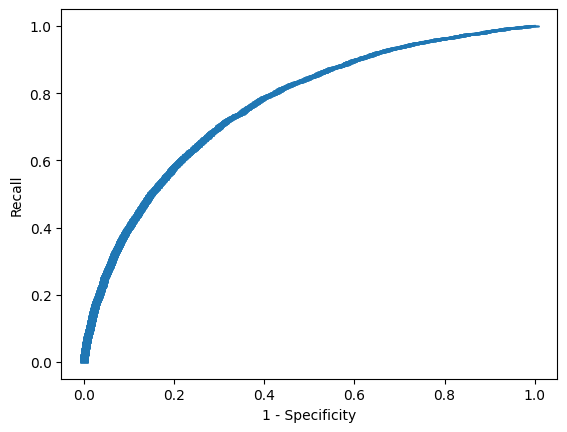

In [82]:
[fpr, tpr, thr] = roc_curve(y_true=y_test, y_score=pipeline.predict_proba(X_test)[:, 1])

# ROC curve
plt.plot(fpr, tpr, marker="_")
plt.xlabel('1 - Specificity')
plt.ylabel('Recall')
plt.show()


In [83]:
# Enregistrement du modèle 
signature = infer_signature(X_train, y_train)
mlflow.sklearn.save_model(pipeline, 'MLFlow Best Model', signature=signature)

# SHAP Values

In [84]:
categorical_list_2 = []
numerical_list_2 = []
for i in X_train.columns.tolist():
    if X_train[i].dtype=='object':
        categorical_list_2.append(i)
    else:
        numerical_list_2.append(i)
        
# Récupérer le nom des catégories
cat = pipeline['preprocessor'].transformers_[1][1]\
      .get_feature_names_out(categorical_list_2)

# Enregistrer le model
classifier = pipeline.named_steps['classifier']

# Nom de l'ensemble des colonnes preprocessed
column_names = numerical_list_2+cat.tolist()

In [85]:
# Generate global Shapley Values
# Preprocess the data
df_preprocess = pd.DataFrame(pipeline.named_steps['preprocessor'].transform(X_train),
                             columns=column_names)

# Get the classifier from the pipeline
classifier = pipeline.named_steps['classifier']

# Create an explainer using the classifier and preprocessed data
explainer = shap.Explainer(classifier, df_preprocess)

# Calculate Shapley values for the preprocessed data
# Set check_additivity=False to disable additivity check
shap_values = explainer(df_preprocess, check_additivity=False)

100%|===================| 245926/246005 [36:08<00:00]        

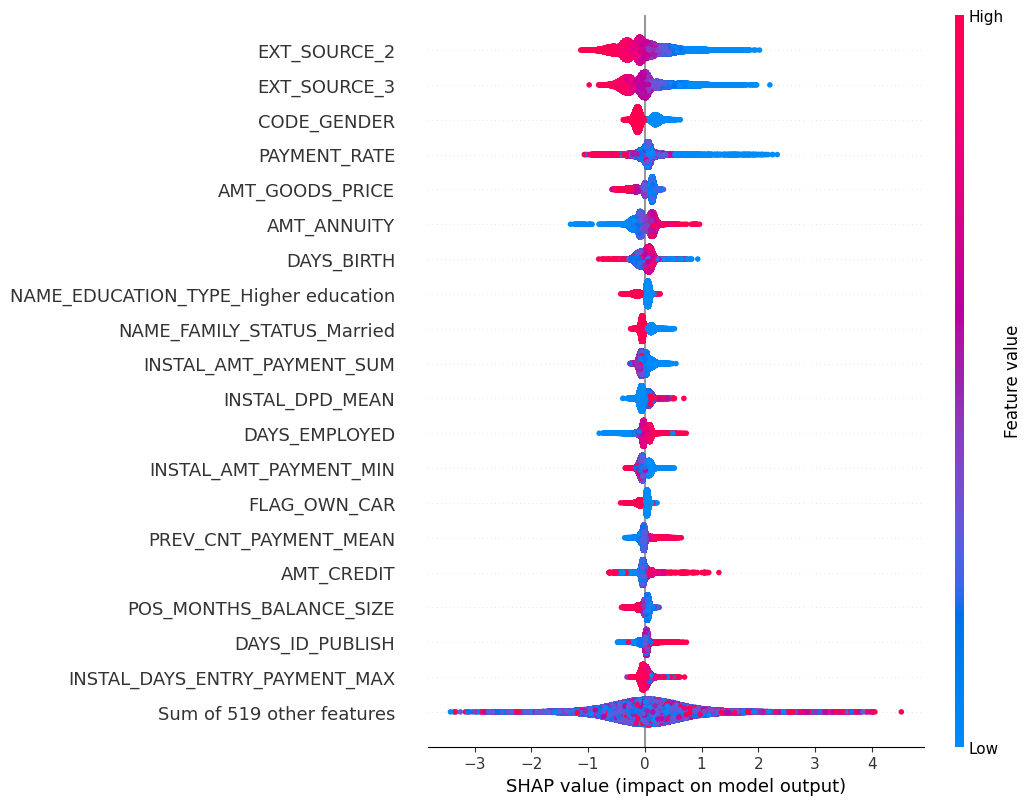

In [86]:
# Afficher interpretabilité globale
shap.plots.beeswarm(shap_values,max_display=20)

In [87]:
# Generate Shapley values for a specific client
# Get the client ID from the X_train index
client_id = X_train.index.tolist()[0]

# Create a list of all IDs in X_train
list_ID = X_train.index.tolist()

# Initialize an empty list to store the indices of the client's ID
index_ID = []

# Iterate over the list of IDs and find the indices that match the client ID
for ind, ID in enumerate(list_ID):
    if list_ID[ind] == client_id:
        index_ID.append(ind)

# Extract the Shapley values for the client using the obtained indices
shap_values_client = shap_values[index_ID][0]


In [88]:
client_id

40682

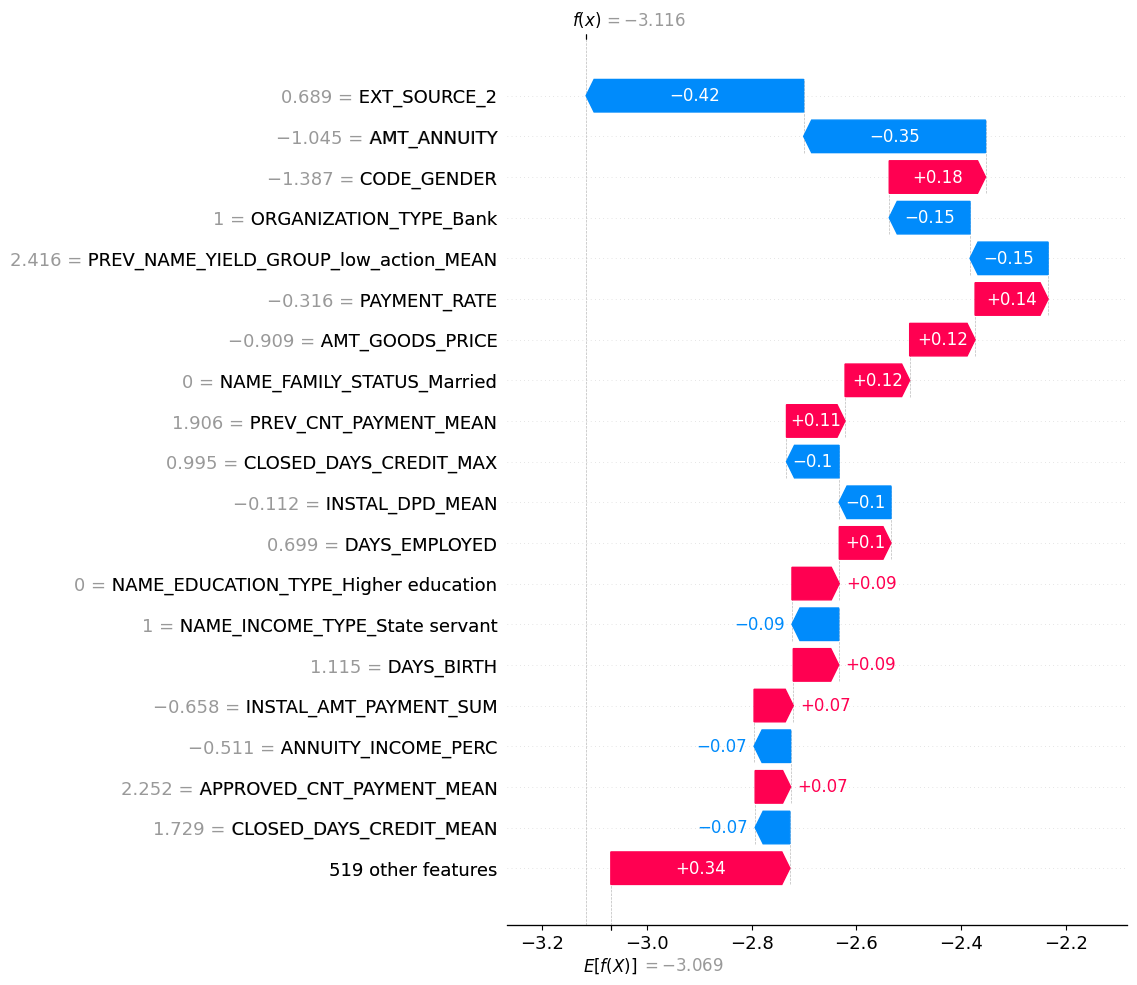

In [89]:
# Afficher interpretabilité locale
shap.plots.waterfall(shap_values_client,max_display=20)